# TESS Atlas fit for TOI 454

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 454.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-454.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-454.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-454.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 454

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 454 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

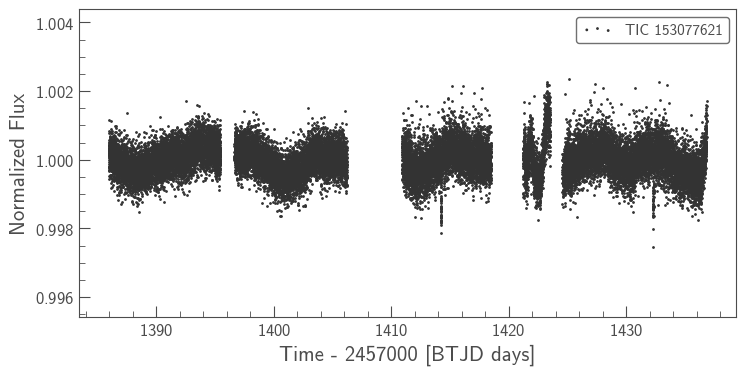

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -20158.279520044816 -> -17136.56711706449


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -36599.15054355293 -> -35177.85450861876


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -35177.85450861876 -> -23849.19754458115


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -23849.19754458115 -> -23849.138476237204


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -23849.138476237204 -> -23849.019413582362


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -23849.019413582362 -> -23848.99457458091


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -23848.99457458091 -> -13911.154325002364


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -13911.154325002366 -> -13911.154325002366


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -13911.154325002364 -> -13911.154325002335


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -13911.154325002335 -> -13911.154325002328


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -13911.154325002328 -> -13911.15432500224


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -13911.15432500224 -> -13911.154325002224


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -13911.154325002224 -> -13911.154325002224


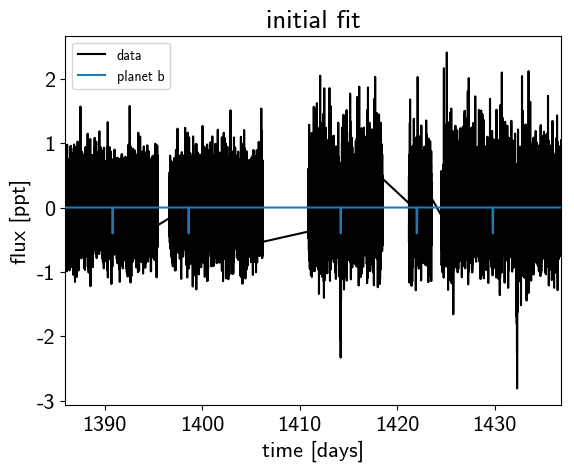

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:08, 11.77draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:01<00:12,  7.52draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:22,  4.22draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:25,  3.56draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:27,  3.31draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:28,  3.14draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:29,  2.98draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:29,  2.95draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:36,  2.42draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:30,  2.83draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:35,  2.42draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:29,  2.82draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:38,  2.15draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:06<00:37,  2.18draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:28,  2.82draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:07<00:33,  2.37draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:07<00:32,  2.42draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:30,  2.55draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:08<00:32,  2.32draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:08<00:29,  2.58draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:09<00:30,  2.44draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:09<00:26,  2.72draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:09<00:27,  2.60draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:10<00:25,  2.80draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:10<00:25,  2.70draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:25,  2.75draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:11<00:21,  3.17draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:11<00:23,  2.89draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:18,  3.60draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:12<00:27,  2.35draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:13<00:26,  2.42draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:13<00:20,  2.96draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:13<00:24,  2.45draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:14<00:23,  2.52draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:14<00:24,  2.46draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:15<00:26,  2.22draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:15<00:21,  2.71draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:16<00:24,  2.26draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:16<00:19,  2.77draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:16<00:22,  2.36draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:17<00:20,  2.58draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:17<00:21,  2.46draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:17<00:19,  2.65draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:18<00:19,  2.57draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:18<00:17,  2.76draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:19<00:18,  2.59draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:19<00:16,  2.78draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:19<00:17,  2.61draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:20<00:17,  2.53draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:20<00:16,  2.59draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:20<00:16,  2.62draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:21<00:19,  2.18draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:22<00:17,  2.26draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:23<00:15,  2.39draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:23<00:14,  2.46draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:24<00:14,  2.41draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:25<00:13,  2.33draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:26<00:12,  2.41draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:26<00:10,  2.73draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:27<00:10,  2.61draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:27<00:10,  2.57draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:27<00:09,  2.77draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:28<00:09,  2.64draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:28<00:08,  2.77draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:28<00:08,  2.87draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:29<00:07,  2.91draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:29<00:07,  2.98draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:29<00:06,  2.99draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:30<00:06,  3.08draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:30<00:06,  2.96draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:30<00:05,  3.11draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:31<00:05,  2.86draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:31<00:04,  3.14draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:31<00:05,  2.73draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:32<00:04,  3.22draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:32<00:04,  2.50draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:33<00:03,  2.60draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:34<00:02,  2.72draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:34<00:02,  2.71draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:35<00:01,  2.79draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:35<00:01,  2.99draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:36<00:00,  2.14draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:38<00:00,  1.18draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:39<00:00,  1.08draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:01, 54.22draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:13,  7.02draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:20,  4.53draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:33,  2.67draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:33,  2.63draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:32,  2.72draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:30,  2.83draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:39,  2.16draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:35,  2.35draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:37,  2.17draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:06<00:29,  2.70draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:38,  2.08draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:07<00:30,  2.57draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:07<00:35,  2.21draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:08<00:34,  2.25draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:08<00:31,  2.40draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:09<00:36,  2.03draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:09<00:31,  2.36draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:09<00:35,  2.04draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:10<00:30,  2.36draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:10<00:30,  2.31draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:11<00:34,  2.04draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:12<00:30,  2.20draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:12<00:26,  2.50draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:12<00:26,  2.47draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:13<00:31,  2.10draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:14<00:28,  2.24draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:14<00:27,  2.29draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:14<00:23,  2.55draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:15<00:28,  2.07draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:15<00:21,  2.70draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:16<00:24,  2.35draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:16<00:25,  2.24draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:16<00:20,  2.67draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:17<00:25,  2.14draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:17<00:19,  2.75draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:18<00:18,  2.85draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:18<00:17,  3.04draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:19<00:23,  2.21draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:19<00:21,  2.28draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:19<00:20,  2.44draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:20<00:24,  1.95draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:21<00:20,  2.24draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:21<00:22,  1.97draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:22<00:20,  2.13draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:22<00:17,  2.39draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:23<00:16,  2.43draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:23<00:19,  2.00draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:24<00:15,  2.52draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:24<00:17,  2.21draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:25<00:20,  1.79draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:26<00:17,  2.00draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:26<00:17,  1.97draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:26<00:13,  2.43draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:27<00:16,  1.96draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:27<00:13,  2.37draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:28<00:13,  2.21draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:28<00:13,  2.08draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:29<00:10,  2.55draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:29<00:13,  2.04draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:30<00:12,  2.16draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:30<00:10,  2.31draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:31<00:11,  2.07draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:31<00:08,  2.70draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:32<00:10,  2.06draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:32<00:09,  2.20draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:32<00:06,  2.78draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:33<00:07,  2.35draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:33<00:06,  2.50draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:34<00:09,  1.72draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:35<00:10,  1.43draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:36<00:09,  1.42draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:36<00:07,  1.76draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:37<00:08,  1.48draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:38<00:08,  1.29draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:39<00:08,  1.18draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:40<00:06,  1.50draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:41<00:06,  1.30draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:42<00:05,  1.19draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:43<00:05,  1.12draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:44<00:04,  1.07draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:45<00:03,  1.06draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:46<00:02,  1.04draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:47<00:01,  1.02draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:48<00:00,  1.02draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:52<00:00,  1.89s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:58,  1.71draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<01:37,  2.08draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:00<01:12,  2.77draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:26,  2.30draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:02<01:28,  2.23draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:22,  2.40draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:03<01:38,  2.00draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:03<01:32,  2.09draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:04<01:12,  2.68draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:24,  2.28draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:05<01:21,  2.34draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:05<01:03,  2.99draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:05<00:55,  3.40draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:06<01:21,  2.31draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:06<01:16,  2.44draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:07<01:11,  2.60draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:07<01:04,  2.86draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:07<00:52,  3.49draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:08<01:05,  2.78draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:08<00:57,  3.14draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:09<01:20,  2.23draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:09<00:59,  2.98draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:10<01:25,  2.06draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:10<01:10,  2.45draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:10<00:54,  3.17draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:11<00:52,  3.27draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:11<00:48,  3.50draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:11<00:45,  3.73draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:11<00:50,  3.33draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:12<00:50,  3.34draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:12<00:41,  3.99draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:13<00:47,  3.50draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:13<00:45,  3.64draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:13<00:53,  3.03draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:14<01:07,  2.40draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:14<00:51,  3.11draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:14<00:52,  3.03draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:15<01:03,  2.49draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:15<00:51,  3.09draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:16<01:08,  2.28draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:16<00:54,  2.86draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:17<01:04,  2.39draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:17<01:03,  2.44draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:17<00:46,  3.29draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:18<00:57,  2.62draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:18<00:58,  2.58draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:18<00:57,  2.61draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:19<00:44,  3.33draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:19<00:36,  3.99draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:19<00:42,  3.43draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:19<00:45,  3.21draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:20<00:56,  2.54draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:20<00:46,  3.05draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:21<01:02,  2.28draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:22<00:57,  2.43draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:22<00:56,  2.47draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:22<00:52,  2.64draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:23<00:54,  2.50draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:23<00:46,  2.94draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:24<00:47,  2.81draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:24<00:39,  3.37draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:24<00:36,  3.58draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:24<00:33,  3.93draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:24<00:25,  5.12draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:25<00:44,  2.89draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:25<00:40,  3.14draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:25<00:32,  3.88draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:26<00:44,  2.81draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:26<00:42,  2.90draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:27<00:35,  3.43draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:27<00:52,  2.32draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:28<00:50,  2.36draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:28<00:39,  3.05draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:28<00:29,  4.00draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:29<00:42,  2.74draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:29<00:34,  3.30draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:30<00:40,  2.81draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:30<00:36,  3.07draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:31<00:40,  2.73draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:31<00:45,  2.42draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:31<00:39,  2.78draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:32<00:50,  2.13draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:32<00:41,  2.53draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:33<00:45,  2.28draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:33<00:39,  2.61draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:33<00:28,  3.55draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:34<00:30,  3.26draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:34<00:41,  2.39draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:35<00:31,  3.05draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:35<00:26,  3.63draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:35<00:25,  3.64draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:36<00:31,  2.91draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:36<00:23,  3.89draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:37<00:30,  2.93draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:37<00:35,  2.47draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:38<00:35,  2.43draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:38<00:34,  2.48draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:39<00:31,  2.68draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:39<00:29,  2.77draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:40<00:35,  2.31draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:40<00:28,  2.85draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:41<00:38,  2.07draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:42<00:35,  2.20draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:42<00:32,  2.37draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:42<00:34,  2.21draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:43<00:33,  2.24draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:43<00:29,  2.49draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:44<00:34,  2.11draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:44<00:26,  2.69draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:45<00:26,  2.59draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:46<00:26,  2.57draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:46<00:22,  2.96draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:46<00:22,  2.93draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:47<00:28,  2.27draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:48<00:27,  2.29draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:48<00:21,  2.88draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:48<00:26,  2.29draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:49<00:24,  2.45draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:49<00:28,  2.11draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:50<00:28,  2.06draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:50<00:25,  2.28draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:51<00:23,  2.40draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:51<00:20,  2.72draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:51<00:20,  2.66draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:51<00:16,  3.14draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:52<00:23,  2.22draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:52<00:20,  2.54draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:53<00:24,  2.02draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:53<00:18,  2.65draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:54<00:24,  1.97draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:54<00:18,  2.48draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:55<00:22,  2.04draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:55<00:19,  2.28draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:56<00:18,  2.32draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:56<00:15,  2.71draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:57<00:18,  2.18draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:57<00:14,  2.70draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:58<00:19,  1.93draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:58<00:15,  2.28draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:59<00:15,  2.31draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:59<00:16,  2.11draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:00<00:11,  2.69draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:00<00:14,  2.08draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:01<00:11,  2.58draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [01:01<00:09,  2.94draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [01:02<00:11,  2.28draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:02<00:10,  2.44draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:03<00:11,  2.13draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:03<00:10,  2.21draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:04<00:11,  2.00draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:04<00:10,  2.19draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:04<00:08,  2.52draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:05<00:07,  2.57draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:05<00:07,  2.57draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:05<00:06,  2.89draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [01:06<00:09,  1.73draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:08<00:13,  1.20draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:08<00:10,  1.45draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:09<00:11,  1.21draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [01:10<00:11,  1.13draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:11<00:09,  1.27draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:11<00:06,  1.61draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:12<00:07,  1.37draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:13<00:06,  1.41draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:14<00:05,  1.38draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:14<00:03,  1.75draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:15<00:04,  1.22draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:16<00:02,  1.51draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:17<00:02,  1.19draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:17<00:01,  1.39draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:18<00:00,  1.26draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:22<00:00,  1.69s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:18, 21.67draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:24, 16.26draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:27, 14.22draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:51,  7.75draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:47,  8.24draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:01<00:50,  7.74draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:01<00:48,  8.06draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<01:04,  6.03draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:01<01:01,  6.38draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:01<00:52,  7.33draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:02<01:01,  6.24draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:02<00:53,  7.21draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:02<00:57,  6.71draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:02<00:49,  7.67draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:02<00:54,  7.01draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:02<00:48,  7.85draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:03<00:43,  8.75draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:03<00:36, 10.24draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:03<00:30, 12.19draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:03<00:28, 12.76draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:03<00:27, 13.36draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:03<00:25, 14.40draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:04<00:27, 13.16draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:04<00:29, 11.99draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:04<00:25, 13.87draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:04<00:22, 15.55draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:04<00:21, 16.65draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:04<00:20, 17.00draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:04<00:23, 14.57draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:05<00:23, 14.46draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:05<00:25, 13.70draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:05<00:22, 14.86draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:05<00:24, 13.55draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:05<00:25, 13.23draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:05<00:20, 15.87draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:06<00:18, 17.37draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:06<00:24, 13.60draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:06<00:36,  8.96draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:06<00:39,  8.13draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:07<00:32,  9.80draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:07<00:31, 10.00draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:07<00:26, 12.04draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:07<00:36,  8.66draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:07<00:30, 10.27draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:08<00:33,  9.18draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:08<00:28, 10.72draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:08<00:25, 11.91draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:08<00:23, 13.04draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:08<00:19, 15.25draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:08<00:17, 17.22draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:08<00:15, 19.39draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:09<00:16, 17.17draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:09<00:16, 17.59draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:09<00:17, 16.81draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:09<00:14, 19.40draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:09<00:13, 21.37draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:09<00:12, 21.64draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:10<00:16, 16.96draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:10<00:17, 15.17draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:10<00:15, 17.63draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:10<00:13, 20.03draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:10<00:11, 21.97draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:10<00:10, 23.78draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:10<00:12, 20.72draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:11<00:10, 23.15draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:11<00:10, 23.48draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:11<00:10, 23.64draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:11<00:09, 24.74draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:11<00:09, 25.65draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:11<00:08, 27.10draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:11<00:07, 29.64draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:11<00:08, 26.92draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:12<00:07, 29.62draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:12<00:07, 28.39draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:12<00:07, 27.49draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:12<00:07, 28.14draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:12<00:06, 29.92draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:12<00:06, 30.46draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:12<00:06, 30.89draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:12<00:06, 30.96draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:13<00:06, 30.47draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:13<00:06, 27.99draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:13<00:06, 29.73draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:13<00:06, 29.80draws/s]

Sampling 2 chains:  56%|█████▋    | 228/404 [00:13<00:06, 25.52draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:13<00:07, 24.43draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:14<00:07, 22.53draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:14<00:07, 21.93draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:14<00:06, 23.44draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:14<00:09, 16.92draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:15<00:14, 11.10draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:15<00:14, 10.69draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:15<00:12, 11.76draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:15<00:11, 12.86draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:15<00:10, 13.55draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:15<00:10, 14.37draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:16<00:10, 13.53draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:16<00:08, 15.54draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:16<00:07, 17.33draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:16<00:07, 17.51draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:16<00:08, 15.95draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:16<00:08, 15.42draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:16<00:07, 17.25draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:17<00:06, 19.45draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:17<00:05, 20.89draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:17<00:04, 25.08draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:17<00:04, 27.34draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:17<00:04, 24.75draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:17<00:03, 27.87draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:17<00:03, 26.41draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:18<00:03, 27.12draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:18<00:03, 27.51draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:18<00:03, 27.13draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [00:18<00:03, 24.57draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:18<00:03, 23.45draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:18<00:03, 21.94draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:18<00:03, 19.12draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:19<00:09,  8.07draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:20<00:08,  8.09draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:20<00:07,  8.79draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:20<00:06, 10.22draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:20<00:06,  9.85draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:20<00:06,  9.32draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:21<00:05, 10.71draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:21<00:04, 11.98draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:21<00:04, 11.62draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:21<00:05, 10.31draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:21<00:04, 10.51draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:21<00:04, 10.66draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:22<00:04,  9.71draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:22<00:04, 11.06draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:22<00:03, 11.01draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:22<00:04,  9.98draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:23<00:04,  8.62draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:23<00:04,  9.20draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:23<00:04,  8.89draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:23<00:04,  8.67draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:23<00:04,  8.52draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:23<00:04,  8.42draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:23<00:05,  6.46draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:24<00:08,  3.95draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:24<00:07,  4.01draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:24<00:07,  4.04draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:25<00:05,  4.92draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:25<00:04,  5.60draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:25<00:04,  6.18draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:25<00:03,  7.60draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:25<00:02,  8.38draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:25<00:02,  9.78draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:25<00:01,  9.98draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:26<00:01, 10.13draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:26<00:01, 11.36draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:26<00:01, 11.13draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:26<00:00, 12.30draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:26<00:00, 13.21draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:26<00:00, 13.96draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:26<00:00, 14.54draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:27<00:00,  8.84draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:27<00:00,  7.44draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/804 [00:00<00:21, 37.60draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:22, 35.43draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:00<00:24, 31.84draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:00<00:47, 16.71draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:00<00:54, 14.37draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:01<01:09, 11.25draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:01<01:08, 11.45draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:01<01:07, 11.62draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:01<00:53, 14.45draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:01<00:46, 16.58draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:01<00:44, 17.21draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:39, 19.27draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:02<00:37, 20.53draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:02<00:44, 17.30draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:02<00:39, 19.09draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:02<00:39, 18.96draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:02<00:37, 20.13draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:02<00:32, 22.90draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:02<00:28, 26.26draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:03<00:27, 27.37draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:03<00:24, 29.86draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:03<00:30, 24.01draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:03<00:32, 22.15draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:03<00:32, 22.40draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:03<00:30, 24.05draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:03<00:26, 26.75draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:04<00:25, 28.58draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:04<00:25, 27.38draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:04<00:22, 31.50draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:04<00:20, 34.12draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:04<00:18, 37.57draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:04<00:18, 38.21draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:04<00:19, 35.81draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:05<00:21, 31.82draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:05<00:21, 32.18draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:05<00:22, 29.45draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:05<00:22, 30.41draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:05<00:20, 32.15draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:05<00:21, 31.15draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:05<00:22, 29.03draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:05<00:22, 29.59draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:06<00:24, 26.30draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:06<00:22, 28.55draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:06<00:21, 29.76draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:06<00:20, 30.71draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:06<00:23, 26.84draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:06<00:20, 30.18draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:06<00:18, 33.04draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:07<00:23, 26.16draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:07<00:23, 25.83draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:07<00:26, 23.10draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:07<00:32, 18.66draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:07<00:31, 19.10draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:08<00:33, 18.30draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:08<00:34, 17.70draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:08<00:29, 20.37draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:08<00:27, 21.78draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:08<00:24, 23.90draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:08<00:25, 22.75draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:08<00:24, 23.64draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:08<00:21, 26.72draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:09<00:20, 28.68draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:09<00:17, 31.92draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [00:09<00:15, 35.47draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:09<00:18, 31.16draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:09<00:18, 29.42draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:09<00:19, 28.09draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [00:09<00:20, 27.29draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:10<00:21, 25.44draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:10<00:21, 25.70draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:10<00:20, 26.58draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:10<00:21, 24.89draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:10<00:22, 24.00draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:10<00:19, 27.23draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:10<00:19, 26.96draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:10<00:22, 23.82draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [00:11<00:21, 24.34draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:11<00:21, 24.69draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:11<00:18, 28.31draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:11<00:16, 31.49draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:11<00:14, 34.05draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:11<00:13, 36.17draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:11<00:13, 36.26draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:11<00:13, 35.04draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:12<00:15, 31.42draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:12<00:22, 21.74draws/s]

Sampling 2 chains:  40%|████      | 325/804 [00:12<00:22, 20.85draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:12<00:25, 19.02draws/s]

Sampling 2 chains:  41%|████      | 331/804 [00:12<00:28, 16.62draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:13<00:28, 16.78draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:13<00:26, 17.58draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:13<00:24, 19.38draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [00:13<00:22, 20.88draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:13<00:22, 20.34draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:13<00:24, 18.55draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:13<00:23, 19.13draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:14<00:22, 20.38draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:14<00:22, 19.98draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:14<00:22, 19.72draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [00:14<00:19, 22.50draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:14<00:17, 25.02draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:14<00:22, 19.46draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [00:14<00:20, 20.98draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:15<00:19, 22.18draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:15<00:18, 23.14draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:15<00:17, 23.61draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:15<00:19, 21.93draws/s]

Sampling 2 chains:  48%|████▊     | 388/804 [00:15<00:19, 21.20draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:15<00:19, 20.70draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [00:15<00:20, 20.21draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:15<00:18, 21.71draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:16<00:17, 22.75draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:16<00:16, 23.99draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:16<00:15, 25.77draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [00:16<00:14, 26.36draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [00:16<00:13, 29.81draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:16<00:12, 31.04draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:16<00:11, 33.96draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [00:16<00:11, 33.55draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [00:17<00:10, 34.78draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:17<00:11, 32.75draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [00:17<00:10, 33.84draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:17<00:09, 35.97draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:17<00:09, 37.65draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [00:17<00:09, 37.27draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:17<00:08, 38.96draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:17<00:09, 36.98draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:18<00:09, 36.09draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:18<00:09, 34.72draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [00:18<00:09, 33.88draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:18<00:08, 36.12draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:18<00:08, 37.91draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:18<00:08, 35.71draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:18<00:08, 34.75draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:19<00:09, 31.47draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:19<00:10, 29.49draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [00:19<00:09, 29.65draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:19<00:09, 31.72draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:19<00:08, 35.07draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:19<00:07, 38.08draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [00:19<00:07, 38.49draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [00:19<00:07, 38.12draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [00:20<00:07, 36.83draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:20<00:06, 38.45draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:20<00:06, 41.49draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:20<00:06, 39.79draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:20<00:06, 36.02draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [00:20<00:06, 36.46draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:20<00:07, 32.46draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:20<00:07, 33.03draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:21<00:06, 33.82draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:21<00:07, 29.98draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:21<00:07, 31.20draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:21<00:06, 32.25draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:21<00:06, 32.89draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:21<00:05, 34.71draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [00:21<00:05, 35.71draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:21<00:05, 35.38draws/s]

Sampling 2 chains:  76%|███████▌  | 610/804 [00:22<00:06, 31.86draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [00:22<00:06, 29.82draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:22<00:05, 32.16draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [00:22<00:05, 32.78draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:22<00:05, 35.29draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [00:22<00:05, 33.90draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:22<00:04, 37.20draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:22<00:04, 35.22draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:23<00:04, 32.77draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:23<00:04, 33.28draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:23<00:03, 37.74draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:23<00:04, 36.01draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [00:23<00:03, 39.70draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:23<00:03, 40.05draws/s]

Sampling 2 chains:  84%|████████▍ | 675/804 [00:23<00:03, 40.69draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:23<00:03, 39.66draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [00:24<00:02, 41.93draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:24<00:02, 44.03draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:24<00:02, 37.99draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [00:24<00:03, 27.51draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:24<00:03, 29.21draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [00:24<00:03, 29.51draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [00:25<00:02, 31.11draws/s]

Sampling 2 chains:  89%|████████▉ | 719/804 [00:25<00:02, 35.27draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [00:25<00:02, 34.98draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [00:25<00:03, 23.90draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [00:25<00:02, 24.35draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:25<00:03, 22.62draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [00:25<00:02, 23.34draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:26<00:02, 23.99draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [00:26<00:02, 20.48draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:26<00:02, 21.73draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [00:26<00:02, 21.64draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [00:26<00:02, 21.77draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:26<00:02, 19.00draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:27<00:02, 17.78draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:27<00:02, 19.55draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:27<00:01, 20.98draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:27<00:01, 22.02draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:27<00:01, 22.95draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [00:27<00:01, 21.52draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:27<00:01, 20.60draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:28<00:01, 21.51draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:28<00:00, 23.87draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:28<00:00, 23.79draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:28<00:00, 24.29draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:28<00:00, 22.36draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:28<00:00, 20.30draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [00:28<00:00, 21.64draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:28<00:00, 20.87draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:29<00:00, 18.63draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<03:13, 22.73draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<03:01, 24.20draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<03:02, 24.03draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<03:17, 22.24draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<03:04, 23.79draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:00<02:56, 24.83draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:00<02:52, 25.46draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:00<02:40, 27.22draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:01<02:48, 25.91draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:01<02:54, 25.12draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:01<03:02, 24.01draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:01<02:59, 24.33draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:01<03:42, 19.58draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:01<04:08, 17.52draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:01<04:03, 17.88draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:02<03:58, 18.25draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:02<03:34, 20.32draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:02<03:40, 19.73draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:02<03:21, 21.54draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:02<03:18, 21.85draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:02<03:21, 21.57draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:02<03:05, 23.39draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:03<03:34, 20.20draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:03<03:41, 19.57draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:03<04:43, 15.30draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:03<06:41, 10.78draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:03<06:23, 11.28draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:04<05:45, 12.53draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:04<05:46, 12.46draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:04<05:14, 13.74draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:04<04:29, 15.99draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:04<03:53, 18.47draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:04<03:28, 20.70draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:04<03:31, 20.35draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:05<05:05, 14.10draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:05<05:18, 13.52draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:05<06:17, 11.40draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:05<05:16, 13.57draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:05<04:49, 14.84draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:06<04:35, 15.60draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:06<04:48, 14.89draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:06<04:33, 15.68draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:06<04:17, 16.63draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:06<04:06, 17.37draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:06<04:01, 17.72draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:06<04:03, 17.56draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:06<03:51, 18.49draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:07<03:31, 20.19draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:07<04:00, 17.75draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:07<04:01, 17.65draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:07<03:43, 19.04draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:07<03:24, 20.80draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:07<03:00, 23.60draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:08<03:23, 20.91draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:08<03:07, 22.61draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:08<03:01, 23.35draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:08<03:01, 23.37draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:08<03:40, 19.20draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:08<03:29, 20.26draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:08<03:24, 20.67draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:09<03:34, 19.74draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:09<03:11, 22.06draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:09<03:07, 22.53draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:09<02:55, 24.07draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:09<03:08, 22.32draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:09<03:17, 21.30draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:09<03:08, 22.39draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:10<02:55, 23.96draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:10<02:47, 25.16draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:10<02:41, 26.10draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:10<02:59, 23.37draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:10<03:18, 21.13draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:10<03:14, 21.52draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:10<03:11, 21.83draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:11<03:24, 20.48draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:11<03:49, 18.20draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:11<05:06, 13.63draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:11<05:29, 12.70draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:11<04:33, 15.29draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:11<04:04, 17.07draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:12<04:04, 17.03draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:12<03:48, 18.27draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:12<03:17, 21.07draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:12<02:50, 24.43draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:12<02:43, 25.35draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:12<02:58, 23.22draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:12<02:29, 27.82draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:12<02:27, 28.15draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:13<02:22, 29.05draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:13<02:32, 27.03draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:13<02:40, 25.69draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:13<02:43, 25.28draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:13<03:11, 21.58draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:13<03:05, 22.26draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:13<03:18, 20.72draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:14<03:34, 19.23draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:14<03:13, 21.30draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:14<03:06, 22.11draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:14<03:03, 22.36draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:14<03:16, 20.92draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:14<03:28, 19.67draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:14<03:20, 20.47draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:15<03:53, 17.57draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:15<04:30, 15.12draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:15<05:50, 11.67draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:15<05:35, 12.20draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:15<05:02, 13.51draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:16<05:46, 11.80draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:16<05:50, 11.64draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:16<05:04, 13.40draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:16<05:07, 13.26draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:16<05:25, 12.52draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:16<04:44, 14.33draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:17<04:26, 15.27draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:17<04:45, 14.25draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:17<05:02, 13.44draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:17<06:53,  9.83draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:17<05:59, 11.29draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:17<05:20, 12.68draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:18<05:25, 12.46draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:18<04:55, 13.72draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:18<04:50, 13.97draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:18<04:38, 14.54draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:18<04:47, 14.08draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:18<04:37, 14.57draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:18<04:43, 14.27draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:19<04:23, 15.35draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:19<04:10, 16.18draws/s]

Sampling 2 chains:   8%|▊         | 362/4404 [00:19<04:17, 15.69draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:19<03:52, 17.36draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:19<03:44, 17.99draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:19<03:41, 18.22draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:19<03:29, 19.27draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [00:19<03:32, 18.92draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:20<03:32, 18.92draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:20<04:03, 16.51draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:20<03:34, 18.74draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:20<03:12, 20.92draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [00:20<02:54, 23.03draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:20<03:05, 21.59draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:21<03:23, 19.65draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:21<04:30, 14.78draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:21<04:40, 14.25draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:21<04:38, 14.36draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:21<04:25, 15.07draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:21<04:15, 15.65draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:22<04:08, 16.06draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:22<04:03, 16.39draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:22<03:42, 17.92draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:22<03:11, 20.76draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:22<02:38, 25.11draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:22<02:32, 25.98draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:22<02:40, 24.75draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:23<02:38, 24.99draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:23<02:43, 24.26draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:23<02:42, 24.41draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:23<03:00, 21.92draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:23<02:46, 23.78draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:23<02:26, 26.94draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:23<02:18, 28.38draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:23<02:13, 29.54draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:24<02:19, 28.19draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:24<02:28, 26.49draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:24<02:34, 25.36draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [00:24<02:28, 26.38draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:24<02:22, 27.51draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:24<02:42, 24.19draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:24<02:35, 25.24draws/s]

Sampling 2 chains:  11%|█         | 489/4404 [00:24<03:00, 21.71draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [00:25<03:00, 21.65draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:25<03:12, 20.32draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:25<03:53, 16.70draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:25<03:54, 16.67draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:25<03:33, 18.28draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:25<03:38, 17.86draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:26<03:19, 19.49draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:26<03:06, 20.87draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:26<02:56, 22.03draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [00:26<02:38, 24.57draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:26<02:24, 26.78draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:26<02:27, 26.34draws/s]

Sampling 2 chains:  12%|█▏        | 530/4404 [00:26<02:21, 27.34draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:26<02:24, 26.83draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:27<02:54, 22.21draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:27<02:45, 23.37draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:27<02:35, 24.80draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:27<02:24, 26.79draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:27<02:38, 24.32draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:27<02:38, 24.25draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:27<03:10, 20.18draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:28<03:00, 21.29draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:28<02:51, 22.46draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:28<02:59, 21.37draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:28<03:19, 19.20draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [00:28<03:23, 18.85draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:28<03:09, 20.17draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:29<03:02, 21.00draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:29<02:53, 22.04draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:29<02:36, 24.40draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [00:29<02:34, 24.68draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:29<02:27, 25.81draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:29<02:19, 27.21draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:29<02:25, 26.18draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:29<02:40, 23.67draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:30<02:38, 23.88draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:30<02:41, 23.53draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:30<02:37, 24.04draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [00:30<02:38, 23.93draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [00:30<02:35, 24.34draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:30<02:55, 21.60draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:30<02:55, 21.47draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:31<03:20, 18.82draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:31<03:06, 20.22draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [00:31<02:55, 21.49draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:31<03:30, 17.89draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:31<03:32, 17.68draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [00:31<03:35, 17.43draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:32<03:49, 16.36draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [00:32<03:22, 18.56draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:32<02:59, 20.87draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:32<03:08, 19.90draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:32<02:49, 22.04draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:32<02:44, 22.79draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [00:32<02:22, 26.23draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:32<02:09, 28.76draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:33<01:53, 32.78draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:33<01:48, 34.24draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:33<01:54, 32.43draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [00:33<02:06, 29.44draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [00:33<02:18, 26.88draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:33<02:40, 23.08draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:33<02:23, 25.79draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:34<02:16, 27.16draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:34<02:03, 29.87draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [00:34<02:08, 28.63draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [00:34<02:07, 28.93draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:34<02:29, 24.66draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:34<02:53, 21.19draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:35<02:54, 21.11draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [00:35<02:41, 22.82draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [00:35<02:36, 23.40draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:35<02:39, 22.93draws/s]

Sampling 2 chains:  17%|█▋        | 738/4404 [00:35<02:41, 22.74draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [00:35<02:52, 21.29draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:35<02:45, 22.15draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [00:36<02:54, 20.98draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [00:36<02:58, 20.51draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [00:36<02:56, 20.72draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [00:36<02:41, 22.57draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:36<02:48, 21.59draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:36<02:55, 20.70draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:36<03:00, 20.20draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:37<03:18, 18.30draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [00:37<03:16, 18.51draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:37<03:40, 16.50draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:37<03:34, 16.93draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [00:37<03:08, 19.22draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [00:37<03:09, 19.13draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:38<03:46, 16.01draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [00:38<03:55, 15.35draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:38<04:11, 14.36draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [00:38<04:24, 13.68draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:38<04:04, 14.75draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [00:38<04:11, 14.36draws/s]

Sampling 2 chains:  18%|█▊        | 796/4404 [00:38<03:55, 15.29draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [00:38<03:39, 16.41draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [00:39<03:16, 18.35draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [00:39<02:58, 20.17draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:39<02:52, 20.80draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [00:39<03:07, 19.13draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [00:39<02:55, 20.46draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:39<02:57, 20.24draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [00:39<02:48, 21.27draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [00:40<03:01, 19.72draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [00:40<02:52, 20.71draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [00:40<02:46, 21.48draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:40<02:40, 22.24draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:40<03:04, 19.35draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:40<02:57, 20.12draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [00:40<02:44, 21.61draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [00:41<02:45, 21.57draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [00:41<02:42, 21.89draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [00:41<02:47, 21.23draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [00:41<02:31, 23.42draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [00:41<02:43, 21.64draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:41<02:43, 21.73draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [00:42<02:49, 20.90draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [00:42<02:45, 21.33draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [00:42<02:47, 21.07draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:42<02:41, 21.85draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:42<02:33, 23.04draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:42<02:35, 22.62draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [00:42<02:46, 21.14draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:43<02:40, 21.94draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [00:43<02:31, 23.21draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [00:43<02:29, 23.50draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:43<02:50, 20.55draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [00:43<02:37, 22.25draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [00:43<02:25, 24.00draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:43<02:29, 23.44draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [00:43<02:26, 23.92draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [00:44<02:23, 24.40draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [00:44<02:26, 23.76draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [00:44<02:32, 22.86draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [00:44<02:32, 22.85draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:44<02:26, 23.79draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [00:44<02:18, 25.10draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [00:44<02:20, 24.76draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [00:44<02:22, 24.37draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [00:45<02:31, 22.88draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [00:45<02:34, 22.43draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [00:45<02:37, 21.98draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:45<02:46, 20.77draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [00:45<02:36, 22.04draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [00:45<02:34, 22.31draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [00:45<02:23, 23.99draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [00:46<02:08, 26.91draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [00:46<02:10, 26.42draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [00:46<01:59, 28.86draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [00:46<02:04, 27.67draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [00:46<02:16, 25.07draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [00:46<02:33, 22.26draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [00:46<02:25, 23.47draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [00:47<02:31, 22.54draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [00:47<02:33, 22.28draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [00:47<02:34, 22.05draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [00:47<02:25, 23.42draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:47<02:26, 23.18draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [00:47<02:17, 24.67draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [00:47<02:11, 25.92draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [00:48<02:21, 23.96draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:48<02:25, 23.34draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:48<02:17, 24.57draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [00:48<02:23, 23.56draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [00:48<02:23, 23.52draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [00:48<02:42, 20.83draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [00:48<02:36, 21.58draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [00:49<02:22, 23.66draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [00:49<02:37, 21.42draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [00:49<02:26, 22.93draws/s]

Sampling 2 chains:  24%|██▎       | 1040/4404 [00:49<02:30, 22.34draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [00:49<02:18, 24.23draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [00:49<02:36, 21.41draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [00:49<02:27, 22.75draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [00:50<02:22, 23.49draws/s]

Sampling 2 chains:  24%|██▍       | 1056/4404 [00:50<02:35, 21.55draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [00:50<02:20, 23.88draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [00:50<02:19, 23.95draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [00:50<02:08, 25.93draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:50<02:01, 27.53draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [00:50<01:49, 30.42draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [00:50<01:41, 32.80draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [00:51<01:59, 27.73draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [00:51<02:28, 22.26draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [00:51<02:58, 18.58draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [00:51<02:53, 19.02draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [00:51<03:17, 16.71draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [00:52<03:02, 18.15draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [00:52<02:52, 19.18draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [00:52<03:01, 18.12draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [00:52<03:01, 18.17draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [00:52<02:42, 20.32draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [00:52<02:30, 21.88draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [00:52<02:20, 23.34draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [00:52<02:12, 24.76draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [00:53<02:09, 25.27draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [00:53<02:07, 25.76draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [00:53<02:07, 25.62draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [00:53<02:02, 26.63draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [00:53<02:01, 26.83draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [00:53<02:03, 26.33draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [00:53<02:06, 25.82draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [00:53<01:53, 28.61draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [00:54<02:02, 26.55draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [00:54<02:04, 26.16draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [00:54<02:19, 23.21draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [00:54<02:18, 23.40draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [00:54<02:20, 23.01draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [00:54<02:13, 24.20draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [00:54<02:28, 21.86draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [00:55<02:54, 18.55draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [00:55<02:39, 20.18draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [00:55<02:22, 22.70draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [00:55<02:11, 24.49draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [00:55<01:55, 27.83draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [00:55<01:46, 30.11draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [00:55<01:40, 31.91draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [00:55<01:40, 31.91draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [00:56<01:42, 31.29draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [00:56<02:01, 26.38draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [00:56<02:05, 25.49draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [00:56<02:35, 20.52draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [00:56<02:45, 19.22draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [00:56<02:39, 20.01draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [00:57<02:28, 21.49draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [00:57<03:01, 17.56draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [00:57<02:58, 17.76draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [00:57<03:17, 16.05draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [00:57<03:36, 14.65draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [00:57<03:10, 16.63draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [00:58<03:20, 15.77draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [00:58<03:20, 15.77draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [00:58<03:20, 15.80draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [00:58<03:20, 15.78draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [00:58<03:55, 13.43draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:58<03:20, 15.76draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [00:58<03:18, 15.85draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [00:58<02:48, 18.68draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [00:59<02:30, 20.85draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [00:59<02:24, 21.71draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [00:59<02:33, 20.40draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [00:59<02:29, 21.05draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [00:59<02:14, 23.36draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [00:59<02:05, 24.95draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [00:59<02:00, 25.93draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [00:59<01:55, 27.06draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [01:00<01:49, 28.46draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [01:00<02:08, 24.29draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [01:00<01:49, 28.49draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [01:00<01:46, 29.25draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [01:00<01:42, 30.19draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [01:00<01:50, 28.01draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [01:00<02:03, 24.97draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [01:01<02:35, 19.94draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [01:01<02:31, 20.34draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [01:01<02:31, 20.44draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [01:01<02:36, 19.73draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [01:01<02:40, 19.23draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [01:02<02:57, 17.34draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [01:02<02:32, 20.17draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [01:02<02:36, 19.60draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [01:02<02:26, 20.90draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [01:02<02:33, 20.02draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [01:02<02:38, 19.36draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [01:02<02:35, 19.69draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [01:03<02:15, 22.59draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [01:03<02:12, 23.03draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [01:03<02:10, 23.41draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [01:03<02:28, 20.54draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [01:03<02:39, 19.08draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [01:03<03:07, 16.23draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [01:04<03:01, 16.72draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [01:04<02:56, 17.21draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [01:04<02:50, 17.75draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [01:04<02:54, 17.31draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [01:04<02:42, 18.65draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [01:04<02:48, 17.99draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [01:04<03:14, 15.52draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [01:04<03:22, 14.91draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [01:05<03:44, 13.45draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [01:05<03:51, 13.04draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [01:05<03:30, 14.29draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [01:05<03:10, 15.83draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [01:05<03:02, 16.51draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [01:05<02:56, 17.02draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [01:05<02:34, 19.43draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [01:06<02:18, 21.61draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [01:06<02:18, 21.57draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [01:06<02:31, 19.81draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [01:06<02:09, 23.05draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [01:06<02:18, 21.59draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [01:06<02:10, 22.86draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [01:06<02:02, 24.37draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [01:07<01:56, 25.48draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [01:07<02:11, 22.60draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [01:07<02:16, 21.81draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [01:07<02:10, 22.76draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [01:07<02:10, 22.71draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [01:07<02:21, 20.90draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [01:07<02:16, 21.70draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [01:08<02:30, 19.62draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [01:08<02:28, 19.92draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [01:08<02:22, 20.76draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [01:08<02:17, 21.39draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [01:08<02:12, 22.21draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [01:08<02:26, 20.12draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [01:08<02:29, 19.67draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [01:09<02:31, 19.39draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [01:09<02:19, 21.00draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [01:09<02:11, 22.28draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [01:09<01:58, 24.72draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [01:09<02:06, 23.06draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [01:09<02:27, 19.73draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [01:10<02:14, 21.59draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [01:10<02:13, 21.80draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [01:10<02:08, 22.57draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [01:10<02:02, 23.68draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [01:10<02:12, 21.85draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [01:10<01:59, 24.23draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [01:10<02:10, 22.11draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [01:11<02:18, 20.81draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [01:11<02:19, 20.77draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [01:11<02:09, 22.34draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [01:11<02:00, 23.89draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [01:11<02:05, 23.00draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [01:11<02:02, 23.44draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [01:11<02:12, 21.63draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [01:11<01:59, 24.02draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [01:12<01:55, 24.79draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [01:12<01:44, 27.42draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [01:12<01:43, 27.67draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [01:12<01:46, 26.83draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [01:12<01:39, 28.63draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [01:12<01:39, 28.67draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [01:12<01:39, 28.58draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [01:12<02:00, 23.65draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [01:13<01:58, 23.90draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [01:13<01:55, 24.58draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [01:13<02:02, 23.13draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [01:13<02:28, 19.02draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [01:13<02:45, 17.06draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [01:13<02:27, 19.11draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [01:14<02:12, 21.25draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [01:14<02:00, 23.44draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [01:14<01:49, 25.59draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [01:14<01:42, 27.39draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [01:14<01:44, 26.76draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [01:14<01:47, 25.98draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [01:14<01:53, 24.76draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [01:14<01:56, 24.09draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [01:15<02:05, 22.32draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [01:15<02:00, 23.07draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [01:15<01:57, 23.73draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [01:15<01:55, 24.03draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [01:15<01:53, 24.44draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [01:15<01:46, 26.05draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [01:15<01:56, 23.76draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [01:16<02:05, 22.02draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [01:16<02:00, 22.87draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [01:16<01:55, 23.98draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [01:16<02:13, 20.62draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [01:16<02:11, 20.91draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [01:16<02:16, 20.18draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [01:17<02:40, 17.11draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [01:17<02:13, 20.56draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [01:17<02:16, 20.11draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [01:17<02:35, 17.64draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [01:17<02:44, 16.66draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [01:17<02:39, 17.13draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [01:17<02:32, 17.91draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [01:18<02:52, 15.81draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [01:18<02:47, 16.24draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [01:18<03:04, 14.81draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [01:18<03:16, 13.88draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [01:18<02:50, 16.00draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [01:18<02:48, 16.18draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [01:18<02:46, 16.29draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [01:19<03:02, 14.87draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [01:19<02:56, 15.33draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [01:19<02:42, 16.64draws/s]

Sampling 2 chains:  39%|███▊      | 1696/4404 [01:19<02:59, 15.08draws/s]

Sampling 2 chains:  39%|███▊      | 1698/4404 [01:19<03:10, 14.18draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [01:19<03:02, 14.81draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [01:20<02:50, 15.80draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [01:20<02:48, 16.03draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [01:20<02:45, 16.29draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [01:20<02:28, 18.16draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [01:20<02:16, 19.71draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [01:20<02:08, 20.95draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [01:20<02:01, 22.04draws/s]

Sampling 2 chains:  39%|███▉      | 1724/4404 [01:20<01:57, 22.80draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [01:21<02:16, 19.67draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [01:21<02:58, 14.96draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [01:21<02:50, 15.64draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [01:21<03:04, 14.50draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [01:21<02:52, 15.49draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [01:22<03:06, 14.30draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [01:22<02:56, 15.07draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [01:22<03:34, 12.40draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [01:22<03:39, 12.12draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [01:22<03:16, 13.49draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [01:22<03:22, 13.09draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [01:23<03:40, 12.03draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [01:23<03:42, 11.93draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [01:23<03:40, 11.98draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [01:23<03:33, 12.40draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [01:23<03:15, 13.53draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [01:24<03:22, 13.00draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [01:24<03:30, 12.49draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:24<03:31, 12.48draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [01:24<03:13, 13.60draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [01:24<03:11, 13.76draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [01:24<03:17, 13.28draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [01:25<03:01, 14.49draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [01:25<02:45, 15.81draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [01:25<02:59, 14.57draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [01:25<02:48, 15.58draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [01:25<02:53, 15.07draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [01:25<02:56, 14.82draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [01:26<02:49, 15.37draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [01:26<02:26, 17.78draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [01:26<02:24, 18.02draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [01:26<02:08, 20.29draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [01:26<02:02, 21.17draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [01:26<02:08, 20.12draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [01:26<02:13, 19.49draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [01:26<02:09, 20.03draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [01:27<02:06, 20.42draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [01:27<02:31, 17.11draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [01:27<02:31, 17.06draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [01:27<02:12, 19.47draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [01:27<02:07, 20.15draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [01:27<01:52, 22.83draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [01:27<01:48, 23.66draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [01:28<01:42, 25.10draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [01:28<01:53, 22.51draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [01:28<01:46, 23.92draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [01:28<01:38, 26.00draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [01:28<01:41, 25.06draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [01:28<01:54, 22.34draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [01:28<02:02, 20.79draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [01:29<01:51, 22.71draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [01:29<01:49, 23.20draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [01:29<01:47, 23.68draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [01:29<01:46, 23.76draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [01:29<01:40, 25.26draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [01:29<01:39, 25.46draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [01:29<01:53, 22.20draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [01:30<01:50, 22.79draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [01:30<01:59, 21.06draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [01:30<02:14, 18.64draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [01:30<02:03, 20.28draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [01:30<02:08, 19.43draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [01:30<01:58, 21.13draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [01:30<01:56, 21.54draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [01:31<01:49, 22.82draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [01:31<02:03, 20.28draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [01:31<01:56, 21.34draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [01:31<01:52, 22.16draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [01:31<01:50, 22.50draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [01:31<01:50, 22.50draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [01:31<01:44, 23.78draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [01:32<01:44, 23.74draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [01:32<01:50, 22.46draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [01:32<01:47, 22.90draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [01:32<01:46, 23.19draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [01:32<01:44, 23.65draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [01:32<01:39, 24.64draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [01:33<02:26, 16.73draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [01:33<02:09, 18.96draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [01:33<02:10, 18.82draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [01:33<02:04, 19.67draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [01:33<01:51, 21.88draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [01:33<01:40, 24.17draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [01:33<01:35, 25.58draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [01:33<01:40, 24.28draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [01:34<01:33, 25.95draws/s]

Sampling 2 chains:  45%|████▍     | 1977/4404 [01:34<01:31, 26.53draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [01:34<01:40, 24.05draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [01:34<01:47, 22.42draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [01:34<01:51, 21.61draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [01:34<01:45, 22.81draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [01:34<01:38, 24.49draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [01:35<01:45, 22.78draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [01:35<01:44, 23.05draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [01:35<01:45, 22.77draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [01:35<01:45, 22.77draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [01:35<01:41, 23.58draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [01:35<01:36, 24.68draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [01:35<01:34, 25.42draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [01:35<01:32, 25.83draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [01:35<01:37, 24.46draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [01:36<01:48, 21.97draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [01:36<02:00, 19.68draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [01:36<02:03, 19.28draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [01:36<01:51, 21.24draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [01:36<01:56, 20.38draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [01:36<02:04, 19.07draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [01:37<02:18, 17.05draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [01:37<02:19, 16.92draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [01:37<02:13, 17.65draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [01:37<02:09, 18.17draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [01:37<02:16, 17.22draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [01:37<02:18, 16.98draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [01:37<02:23, 16.39draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [01:38<02:24, 16.22draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:38<02:34, 15.19draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [01:38<02:29, 15.65draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [01:38<02:29, 15.65draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [01:38<02:28, 15.72draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [01:38<02:11, 17.72draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [01:38<02:20, 16.66draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [01:38<02:11, 17.77draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [01:39<02:12, 17.63draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [01:39<02:07, 18.26draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [01:39<02:04, 18.73draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [01:39<02:09, 18.02draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [01:39<02:00, 19.29draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [01:39<02:03, 18.84draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [01:39<02:04, 18.58draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [01:39<02:02, 18.87draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [01:40<01:52, 20.56draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [01:40<01:53, 20.39draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [01:40<02:05, 18.39draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [01:40<02:23, 16.10draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [01:40<02:23, 16.04draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [01:40<02:16, 16.89draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [01:41<02:57, 12.91draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [01:41<02:48, 13.64draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [01:41<02:31, 15.11draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [01:41<02:33, 14.96draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [01:41<02:40, 14.27draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [01:41<02:29, 15.24draws/s]

Sampling 2 chains:  48%|████▊     | 2122/4404 [01:41<02:20, 16.21draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [01:42<02:17, 16.53draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [01:42<02:14, 16.99draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [01:42<02:16, 16.68draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [01:42<02:10, 17.36draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [01:42<01:58, 19.10draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [01:42<02:04, 18.29draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [01:42<02:13, 16.97draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [01:43<02:37, 14.40draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [01:43<02:15, 16.71draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [01:43<02:25, 15.48draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [01:43<02:18, 16.32draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [01:43<02:16, 16.57draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [01:43<02:09, 17.43draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [01:43<02:06, 17.78draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [01:43<02:01, 18.52draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [01:44<01:56, 19.32draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [01:44<01:57, 18.99draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [01:44<01:45, 21.20draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [01:44<01:39, 22.48draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [01:44<01:41, 21.92draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [01:44<01:41, 22.01draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [01:44<01:40, 22.12draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [01:45<01:46, 20.85draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [01:45<01:38, 22.60draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [01:45<01:35, 23.09draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [01:45<01:36, 23.03draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:45<01:42, 21.57draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [01:45<01:48, 20.26draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [01:45<02:02, 17.92draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [01:46<01:49, 20.10draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [01:46<01:39, 21.97draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [01:46<01:32, 23.70draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [01:46<01:25, 25.45draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [01:46<01:25, 25.70draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [01:46<01:38, 22.09draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [01:46<01:49, 19.96draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [01:47<01:54, 18.94draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [01:47<01:59, 18.17draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [01:47<02:24, 15.04draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [01:47<02:24, 15.05draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [01:47<02:38, 13.69draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [01:48<02:29, 14.48draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [01:48<02:46, 13.00draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [01:48<02:50, 12.68draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [01:48<02:55, 12.29draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [01:48<02:59, 12.04draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [01:48<02:58, 12.08draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [01:49<02:43, 13.19draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [01:49<02:44, 13.06draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [01:49<02:29, 14.35draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [01:49<02:43, 13.15draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [01:49<02:55, 12.22draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [01:49<02:58, 12.01draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [01:50<02:44, 13.04draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [01:50<02:22, 14.98draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [01:50<02:19, 15.35draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [01:50<02:14, 15.79draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [01:50<02:17, 15.48draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [01:50<02:11, 16.22draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [01:50<02:04, 17.09draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [01:51<01:55, 18.38draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [01:51<02:00, 17.58draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [01:51<01:56, 18.18draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [01:51<01:49, 19.30draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [01:51<01:53, 18.54draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [01:51<01:57, 17.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [01:51<01:49, 19.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [01:52<01:42, 20.44draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [01:52<01:36, 21.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [01:52<01:43, 20.28draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [01:52<01:34, 22.05draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [01:52<01:31, 22.85draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [01:52<01:23, 24.97draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [01:52<01:30, 23.07draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [01:52<01:29, 23.33draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [01:53<01:35, 21.84draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [01:53<01:35, 21.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [01:53<01:34, 21.90draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [01:53<01:40, 20.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [01:53<01:43, 19.88draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [01:53<01:43, 19.98draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [01:53<01:41, 20.36draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [01:54<01:40, 20.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [01:54<01:46, 19.21draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [01:54<01:47, 19.02draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [01:54<01:44, 19.56draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [01:54<01:41, 20.12draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [01:54<01:44, 19.50draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [01:55<01:44, 19.46draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [01:55<01:44, 19.47draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [01:55<01:50, 18.33draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [01:55<01:55, 17.57draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [01:55<01:56, 17.40draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [01:55<01:46, 19.10draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [01:55<01:44, 19.33draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [01:55<01:51, 18.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [01:56<01:37, 20.68draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [01:56<01:32, 21.79draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [01:56<01:38, 20.45draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [01:56<01:43, 19.36draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [01:56<01:34, 21.26draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [01:56<01:32, 21.56draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [01:56<01:39, 20.16draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [01:57<01:41, 19.64draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [01:57<01:44, 19.16draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [01:57<01:45, 18.92draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [01:57<01:35, 20.85draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [01:57<01:32, 21.42draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [01:57<01:26, 22.82draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [01:58<02:03, 16.05draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [01:58<02:06, 15.61draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [01:58<01:52, 17.51draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [01:58<01:54, 17.22draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [01:58<01:39, 19.83draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [01:58<01:33, 20.86draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [01:59<01:27, 22.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [01:59<01:32, 21.24draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [01:59<01:39, 19.58draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [01:59<01:34, 20.53draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [01:59<01:46, 18.20draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [01:59<01:46, 18.26draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [01:59<01:35, 20.42draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [02:00<01:31, 21.14draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [02:00<01:40, 19.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [02:00<01:34, 20.37draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [02:00<01:32, 20.88draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [02:00<01:35, 20.10draws/s]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [02:00<01:36, 19.93draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [02:00<01:36, 19.98draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [02:01<01:31, 20.89draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [02:01<01:22, 23.14draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [02:01<01:32, 20.71draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [02:01<01:36, 19.71draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [02:01<01:26, 21.90draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [02:01<01:26, 21.85draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [02:02<01:24, 22.39draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [02:02<01:30, 20.87draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [02:02<01:25, 22.06draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [02:02<01:25, 22.16draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [02:02<01:22, 22.72draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [02:02<01:13, 25.45draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [02:02<01:21, 23.15draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [02:02<01:15, 24.94draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [02:03<01:18, 23.81draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [02:03<01:23, 22.45draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [02:03<01:17, 23.99draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [02:03<01:17, 23.90draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [02:03<01:19, 23.35draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [02:03<01:32, 20.14draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [02:04<01:35, 19.46draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [02:04<01:43, 17.92draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [02:04<01:49, 16.82draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [02:04<01:59, 15.42draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [02:04<01:53, 16.27draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [02:04<01:51, 16.56draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [02:04<01:46, 17.35draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [02:05<01:48, 16.92draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [02:05<01:42, 17.89draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [02:05<02:02, 14.90draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [02:05<01:51, 16.45draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [02:05<01:50, 16.55draws/s]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [02:05<01:57, 15.46draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [02:05<01:54, 15.98draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [02:05<01:48, 16.82draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [02:06<01:43, 17.53draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [02:06<01:39, 18.16draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [02:06<01:33, 19.39draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [02:06<01:28, 20.47draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [02:06<01:26, 20.94draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [02:06<01:31, 19.72draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [02:06<01:26, 20.75draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [02:07<01:19, 22.51draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [02:07<01:17, 23.23draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [02:07<01:15, 23.75draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [02:07<01:10, 25.19draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [02:07<01:10, 25.38draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [02:07<01:09, 25.72draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [02:07<01:11, 24.95draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [02:07<01:08, 25.87draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [02:08<01:06, 26.77draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [02:08<01:12, 24.41draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [02:08<01:07, 26.08draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [02:08<01:03, 27.77draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [02:08<00:57, 30.51draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [02:08<01:06, 26.46draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [02:08<01:12, 24.10draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [02:09<01:20, 21.55draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [02:09<01:20, 21.76draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [02:09<01:24, 20.63draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [02:09<01:19, 21.71draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [02:09<01:12, 23.89draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [02:09<01:16, 22.49draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [02:09<01:11, 24.22draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [02:10<01:19, 21.64draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [02:10<01:19, 21.54draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [02:10<01:13, 23.43draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [02:10<01:18, 21.78draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [02:10<01:14, 22.91draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [02:10<01:12, 23.58draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [02:10<01:16, 22.23draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [02:11<01:20, 21.08draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [02:11<01:24, 19.99draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [02:11<01:29, 18.84draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [02:11<01:19, 21.29draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [02:11<01:16, 22.11draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [02:11<01:19, 21.22draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [02:12<01:27, 19.27draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [02:12<01:40, 16.62draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [02:12<01:41, 16.55draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [02:12<01:46, 15.77draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [02:12<01:35, 17.44draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [02:12<01:37, 17.16draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [02:12<01:38, 16.93draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [02:13<01:50, 15.00draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [02:13<01:48, 15.29draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [02:13<01:47, 15.50draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [02:13<01:45, 15.63draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [02:13<01:43, 15.95draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [02:13<01:59, 13.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [02:14<01:44, 15.74draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [02:14<01:38, 16.65draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [02:14<01:39, 16.49draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [02:14<01:35, 17.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [02:14<01:31, 17.97draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [02:14<01:28, 18.49draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [02:14<01:35, 17.10draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [02:14<01:28, 18.55draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [02:15<01:47, 15.18draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [02:15<01:45, 15.43draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [02:15<01:33, 17.47draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [02:15<01:33, 17.38draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [02:15<01:34, 17.13draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [02:15<01:25, 18.92draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [02:15<01:24, 19.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [02:15<01:29, 18.10draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [02:16<01:31, 17.61draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [02:16<01:24, 18.94draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [02:16<01:36, 16.63draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [02:16<01:35, 16.74draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [02:16<01:30, 17.64draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [02:16<01:20, 19.79draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [02:16<01:21, 19.57draws/s]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [02:17<01:37, 16.41draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [02:17<01:33, 16.95draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [02:17<01:48, 14.66draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [02:17<01:38, 16.12draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [02:17<01:37, 16.19draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [02:18<01:36, 16.27draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [02:18<01:23, 18.86draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [02:18<01:25, 18.39draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [02:18<01:26, 18.22draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [02:18<01:26, 18.06draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [02:18<01:26, 17.99draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [02:18<01:32, 16.94draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [02:19<01:30, 17.22draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [02:19<01:19, 19.55draws/s]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [02:19<01:21, 19.11draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [02:19<01:18, 19.63draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [02:19<01:14, 20.85draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [02:19<01:07, 22.94draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [02:19<01:02, 24.54draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [02:20<01:02, 24.69draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [02:20<01:04, 23.75draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [02:20<01:05, 23.36draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [02:20<01:04, 23.71draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [02:20<01:05, 23.41draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [02:20<01:07, 22.58draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [02:20<01:12, 20.80draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [02:21<01:17, 19.60draws/s]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [02:21<01:30, 16.66draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [02:21<01:31, 16.54draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [02:21<01:39, 15.16draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [02:21<01:36, 15.54draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [02:21<01:31, 16.36draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [02:22<01:18, 19.09draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [02:22<01:10, 21.21draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [02:22<01:02, 23.78draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [02:22<01:00, 24.75draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [02:22<01:02, 23.70draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [02:22<01:06, 22.26draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [02:22<01:04, 22.88draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [02:22<00:57, 25.55draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [02:23<00:59, 24.56draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [02:23<00:52, 27.66draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [02:23<00:58, 25.16draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [02:23<01:06, 21.95draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [02:23<01:12, 20.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [02:23<01:07, 21.57draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [02:23<01:06, 21.67draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [02:24<01:07, 21.29draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [02:24<01:08, 20.95draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [02:24<01:35, 15.10draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [02:24<01:47, 13.40draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [02:24<01:36, 14.96draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [02:25<01:37, 14.72draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [02:25<01:40, 14.25draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [02:25<01:35, 15.02draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [02:25<01:33, 15.20draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [02:25<01:32, 15.33draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [02:25<01:32, 15.36draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [02:26<01:32, 15.34draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [02:26<01:30, 15.60draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [02:26<01:24, 16.66draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [02:26<01:26, 16.44draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [02:26<01:23, 16.86draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [02:26<01:30, 15.53draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [02:26<01:22, 16.98draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [02:27<01:25, 16.37draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [02:27<01:21, 17.09draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [02:27<01:23, 16.82draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [02:27<01:23, 16.76draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [02:27<01:37, 14.29draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [02:27<01:32, 14.98draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [02:27<01:26, 15.99draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [02:28<01:22, 16.88draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [02:28<01:32, 15.00draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [02:28<01:25, 16.08draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [02:28<01:25, 16.17draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [02:28<01:28, 15.54draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [02:28<01:30, 15.16draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [02:28<01:29, 15.36draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [02:28<01:19, 17.25draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [02:29<01:23, 16.36draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [02:29<01:21, 16.70draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [02:29<01:15, 18.05draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [02:29<01:10, 19.24draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [02:29<01:09, 19.68draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [02:29<01:05, 20.56draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [02:29<01:05, 20.69draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [02:30<01:05, 20.73draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [02:30<01:06, 20.12draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [02:30<01:20, 16.64draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [02:30<01:19, 16.76draws/s]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [02:30<01:20, 16.55draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [02:30<01:10, 18.85draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [02:31<01:06, 20.06draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [02:31<01:03, 20.90draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [02:31<01:01, 21.41draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [02:31<00:57, 22.95draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [02:31<00:56, 23.18draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [02:31<00:52, 24.88draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [02:31<00:49, 26.53draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [02:32<00:59, 21.84draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [02:32<00:56, 22.95draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [02:32<00:53, 24.53draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [02:32<00:53, 24.39draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [02:32<00:55, 23.49draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [02:32<00:56, 23.03draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [02:32<00:52, 24.46draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [02:32<00:52, 24.49draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [02:33<00:52, 24.39draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [02:33<00:54, 23.41draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [02:33<00:59, 21.32draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [02:33<00:59, 21.32draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [02:33<01:05, 19.27draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [02:33<01:10, 17.89draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [02:34<01:05, 19.15draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [02:34<01:06, 18.95draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [02:34<01:01, 20.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [02:34<01:00, 20.81draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [02:34<00:58, 21.45draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [02:34<00:52, 23.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [02:34<00:49, 25.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [02:35<00:50, 24.62draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [02:35<00:56, 21.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [02:35<00:50, 24.25draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [02:35<00:50, 24.12draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [02:35<00:51, 23.92draws/s]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [02:35<00:55, 22.16draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [02:35<00:51, 23.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [02:36<00:48, 25.07draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [02:36<00:53, 22.59draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [02:36<00:52, 23.09draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [02:36<00:51, 23.57draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [02:36<00:47, 25.12draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [02:36<00:57, 20.97draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [02:36<00:49, 24.09draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [02:37<00:56, 21.20draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [02:37<00:56, 21.21draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [02:37<00:59, 19.79draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [02:37<01:02, 18.88draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [02:37<00:56, 20.88draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [02:37<01:02, 18.88draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [02:38<01:00, 19.36draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [02:38<00:58, 20.05draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [02:38<01:00, 19.24draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [02:38<01:02, 18.59draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [02:38<01:02, 18.46draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [02:38<00:55, 20.78draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [02:39<00:53, 21.70draws/s]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [02:39<00:54, 21.10draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [02:39<00:50, 22.88draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [02:39<00:57, 19.94draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [02:39<01:01, 18.54draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [02:39<00:57, 19.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [02:39<00:55, 20.50draws/s]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [02:40<00:57, 19.59draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [02:40<00:52, 21.28draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [02:40<01:02, 18.01draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [02:40<01:02, 17.91draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [02:40<00:56, 19.62draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [02:40<00:56, 19.83draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [02:41<00:53, 20.79draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [02:41<00:52, 21.00draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [02:41<00:51, 21.26draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [02:41<00:52, 20.81draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [02:41<00:48, 22.45draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [02:41<00:50, 21.81draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [02:41<00:43, 25.24draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [02:42<00:43, 25.23draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [02:42<00:48, 22.41draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [02:42<00:47, 22.90draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [02:42<00:45, 23.77draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [02:42<00:47, 22.48draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [02:42<00:48, 22.14draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [02:42<00:52, 20.40draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [02:43<00:52, 20.38draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [02:43<00:55, 19.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [02:43<00:49, 21.35draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [02:43<00:46, 22.50draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [02:43<00:43, 23.97draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [02:43<00:45, 22.87draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [02:43<00:44, 23.57draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [02:43<00:43, 24.20draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [02:44<00:49, 20.90draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [02:44<00:52, 19.82draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [02:44<00:48, 21.30draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [02:44<00:49, 20.90draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [02:44<00:44, 22.91draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [02:44<00:40, 25.07draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [02:45<00:42, 24.13draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [02:45<00:41, 24.39draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [02:45<00:42, 23.87draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [02:45<00:48, 20.69draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [02:45<00:52, 19.18draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [02:45<00:51, 19.49draws/s]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [02:45<00:49, 20.38draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [02:46<00:49, 20.27draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [02:46<00:54, 18.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [02:46<00:51, 19.27draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [02:46<00:54, 18.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [02:46<00:59, 16.52draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [02:46<00:53, 18.54draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [02:47<01:04, 15.22draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [02:47<01:01, 15.96draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [02:47<01:04, 15.09draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [02:47<01:04, 15.11draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [02:47<00:58, 16.74draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [02:47<00:57, 17.02draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [02:47<00:56, 17.24draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [02:48<00:56, 17.19draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [02:48<00:55, 17.39draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [02:48<01:00, 15.94draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [02:48<00:59, 16.21draws/s]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [02:48<00:53, 17.87draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [02:48<00:53, 17.84draws/s]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [02:48<00:59, 15.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [02:49<00:57, 16.49draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [02:49<00:53, 17.64draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [02:49<00:48, 19.41draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [02:49<00:47, 19.87draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [02:49<00:49, 18.96draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [02:49<00:50, 18.64draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [02:49<00:50, 18.55draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [02:50<00:48, 19.25draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [02:50<00:42, 21.49draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [02:50<00:42, 21.72draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [02:50<00:40, 22.61draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [02:50<00:37, 24.23draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [02:50<00:37, 24.31draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [02:50<00:38, 23.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [02:51<00:40, 22.50draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [02:51<00:45, 20.00draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [02:51<00:41, 21.87draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [02:51<00:36, 24.33draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [02:51<00:33, 26.26draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [02:51<00:33, 26.47draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [02:51<00:33, 26.24draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [02:52<00:31, 28.22draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [02:52<00:32, 27.26draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [02:52<00:35, 24.26draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [02:52<00:33, 25.68draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [02:52<00:41, 20.83draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [02:52<00:39, 22.15draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [02:52<00:39, 22.07draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [02:52<00:37, 23.14draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [02:53<00:33, 25.67draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [02:53<00:33, 25.73draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [02:53<00:30, 27.88draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [02:53<00:28, 29.42draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [02:53<00:29, 28.36draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [02:53<00:30, 27.76draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [02:53<00:30, 27.01draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [02:53<00:30, 26.90draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [02:54<00:31, 26.45draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [02:54<00:31, 26.39draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [02:54<00:28, 28.38draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [02:54<00:29, 27.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [02:54<00:29, 27.08draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [02:54<00:28, 28.81draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [02:54<00:28, 28.08draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [02:54<00:27, 29.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [02:55<00:25, 30.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [02:55<00:27, 29.31draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [02:55<00:28, 27.89draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [02:55<00:28, 27.51draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [02:55<00:26, 29.33draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [02:55<00:27, 28.01draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [02:55<00:28, 27.37draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [02:56<00:26, 29.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [02:56<00:27, 28.08draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [02:56<00:25, 29.75draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [02:56<00:26, 28.55draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [02:56<00:27, 27.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [02:56<00:30, 24.65draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [02:56<00:32, 22.87draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [02:56<00:31, 23.72draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [02:57<00:30, 24.07draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [02:57<00:44, 16.77draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [02:57<00:41, 17.66draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [02:57<00:40, 18.17draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [02:57<00:39, 18.55draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [02:58<00:35, 20.28draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [02:58<00:32, 22.08draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [02:58<00:35, 20.20draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [02:58<00:34, 21.01draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [02:58<00:31, 22.62draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [02:58<00:35, 20.05draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [02:59<00:42, 16.52draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [02:59<00:42, 16.58draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [02:59<00:42, 16.64draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [02:59<00:41, 16.72draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [02:59<00:41, 16.71draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [02:59<00:41, 16.75draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [02:59<00:41, 16.75draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [02:59<00:41, 16.77draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [02:59<00:41, 16.77draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [03:00<00:41, 16.82draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [03:00<00:44, 15.36draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [03:00<00:47, 14.52draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [03:00<00:44, 15.20draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [03:00<00:43, 15.72draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [03:00<00:48, 14.09draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [03:00<00:49, 13.65draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [03:01<00:51, 13.23draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [03:01<00:44, 15.07draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [03:01<00:38, 17.23draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [03:01<00:39, 16.71draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [03:01<00:39, 16.86draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [03:01<00:35, 18.76draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [03:01<00:34, 18.94draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [03:02<00:31, 20.58draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [03:02<00:29, 21.92draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [03:02<00:28, 22.96draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [03:02<00:27, 23.75draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [03:02<00:29, 22.18draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [03:02<00:30, 21.25draws/s]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [03:02<00:28, 22.31draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [03:03<00:29, 21.18draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [03:03<00:28, 22.30draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [03:03<00:27, 23.19draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [03:03<00:28, 21.80draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [03:03<00:26, 23.59draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [03:03<00:28, 21.94draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [03:03<00:29, 21.02draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [03:04<00:34, 17.70draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [03:04<00:38, 15.96draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [03:04<00:37, 16.16draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [03:04<00:40, 15.00draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [03:04<00:38, 15.53draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [03:04<00:41, 14.66draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [03:04<00:42, 14.08draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [03:05<00:40, 14.88draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [03:05<00:42, 14.17draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [03:05<00:43, 13.75draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [03:05<00:44, 13.43draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [03:05<00:41, 14.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [03:05<00:42, 13.85draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [03:05<00:40, 14.59draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [03:06<00:54, 10.65draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [03:06<00:49, 11.87draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [03:06<00:53, 10.89draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [03:06<00:56, 10.30draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [03:06<00:48, 11.84draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [03:07<00:52, 11.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [03:07<00:55, 10.26draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [03:07<00:48, 11.72draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [03:07<00:53, 10.67draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [03:07<00:56,  9.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [03:08<00:54, 10.37draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [03:08<01:01,  9.21draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [03:08<01:04,  8.76draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [03:08<01:04,  8.76draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [03:08<01:03,  8.78draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [03:08<01:06,  8.39draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [03:08<01:06,  8.42draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [03:09<01:04,  8.60draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [03:09<01:03,  8.72draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [03:09<01:05,  8.46draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [03:09<01:10,  7.84draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [03:09<01:08,  8.06draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [03:09<01:07,  8.23draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [03:09<01:05,  8.36draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [03:09<01:04,  8.49draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [03:10<00:59,  9.23draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [03:10<01:00,  9.01draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [03:10<01:01,  8.90draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [03:10<00:58,  9.36draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [03:10<00:59,  9.07draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [03:10<01:00,  8.95draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [03:10<00:51, 10.48draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [03:11<00:49, 10.83draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [03:11<00:57,  9.26draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [03:11<00:54,  9.83draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [03:11<00:51, 10.30draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [03:11<00:54,  9.80draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [03:12<00:56,  9.37draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [03:12<00:54,  9.63draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [03:12<00:52,  9.90draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [03:12<00:57,  9.11draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [03:12<01:05,  7.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [03:13<01:05,  7.89draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [03:13<01:04,  7.99draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [03:13<01:04,  8.02draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [03:13<01:03,  8.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [03:13<01:03,  8.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [03:13<01:02,  8.27draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [03:13<01:02,  8.27draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [03:13<01:01,  8.28draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [03:14<01:02,  8.21draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [03:14<01:06,  7.63draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [03:14<01:06,  7.67draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [03:14<01:10,  7.20draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [03:14<01:10,  7.22draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [03:14<01:10,  7.21draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [03:14<01:07,  7.50draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [03:14<01:03,  7.89draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [03:15<01:01,  8.18draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [03:15<00:59,  8.46draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [03:15<00:55,  8.99draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [03:15<00:51,  9.71draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [03:15<00:45, 10.84draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [03:15<00:40, 12.21draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [03:15<00:41, 11.89draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [03:16<00:35, 13.80draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [03:16<00:31, 15.48draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [03:16<00:28, 17.07draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [03:16<00:27, 17.38draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [03:16<00:26, 17.93draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [03:16<00:25, 18.57draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [03:16<00:29, 16.19draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [03:17<00:32, 14.69draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [03:17<00:35, 13.14draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [03:17<00:49,  9.49draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [03:17<00:52,  8.83draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [03:18<00:55,  8.40draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [03:18<00:53,  8.65draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [03:18<00:53,  8.64draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [03:18<00:57,  8.08draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [03:18<00:50,  9.17draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [03:18<00:50,  9.13draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [03:19<00:53,  8.45draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [03:19<00:49,  9.09draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [03:19<00:47,  9.55draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [03:19<00:41, 10.95draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [03:19<00:39, 11.44draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [03:20<00:46,  9.67draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [03:20<01:02,  7.10draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [03:20<01:34,  4.69draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [03:21<01:25,  5.18draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [03:21<01:26,  5.12draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [03:21<01:22,  5.35draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [03:21<01:19,  5.53draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [03:21<01:17,  5.67draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [03:21<01:15,  5.77draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [03:22<01:09,  6.25draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [03:22<00:59,  7.30draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [03:22<00:52,  8.27draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [03:22<00:57,  7.44draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [03:22<00:51,  8.37draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [03:22<00:48,  8.76draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [03:23<00:47,  8.90draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [03:23<00:43,  9.75draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [03:23<00:49,  8.54draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [03:23<00:50,  8.37draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [03:23<00:49,  8.57draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [03:23<00:48,  8.70draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [03:23<00:47,  8.79draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [03:24<00:45,  9.22draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [03:24<00:45,  9.05draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [03:24<00:46,  8.99draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [03:24<00:43,  9.56draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [03:24<00:43,  9.40draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [03:24<00:50,  8.13draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [03:25<01:06,  6.12draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [03:25<01:16,  5.29draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [03:25<01:23,  4.87draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [03:25<01:12,  5.57draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [03:25<01:05,  6.17draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [03:26<00:57,  6.98draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [03:26<00:54,  7.40draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [03:26<00:53,  7.53draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [03:26<00:51,  7.69draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [03:26<00:49,  7.98draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [03:26<00:41,  9.50draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [03:26<00:38, 10.14draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [03:27<00:38, 10.13draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [03:27<00:36, 10.64draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [03:27<00:35, 10.98draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [03:27<00:34, 11.23draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [03:27<00:33, 11.32draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [03:27<00:29, 12.76draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [03:28<00:28, 13.11draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [03:28<00:24, 15.13draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [03:28<00:23, 15.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [03:28<00:24, 14.92draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [03:28<00:25, 14.43draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [03:28<00:26, 14.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [03:28<00:25, 14.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [03:29<00:26, 13.76draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [03:29<00:27, 13.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [03:29<00:28, 12.87draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [03:29<00:28, 12.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [03:29<00:26, 13.56draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [03:29<00:27, 12.99draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [03:29<00:27, 12.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [03:30<00:24, 14.05draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [03:30<00:25, 13.43draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [03:30<00:24, 14.33draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [03:30<00:20, 16.72draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [03:30<00:24, 13.98draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [03:31<00:32, 10.41draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [03:31<00:32, 10.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [03:31<00:31, 10.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [03:31<00:31, 10.52draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [03:31<00:34,  9.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [03:32<00:35,  9.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [03:32<00:36,  8.88draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [03:32<00:38,  8.52draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [03:32<00:40,  8.08draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [03:32<00:39,  8.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [03:32<00:43,  7.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [03:33<00:54,  5.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [03:33<00:58,  5.53draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [03:33<00:55,  5.79draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [03:33<00:51,  6.14draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [03:33<00:46,  6.83draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [03:33<00:39,  8.04draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [03:34<00:37,  8.28draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [03:34<00:32,  9.65draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [03:34<00:37,  8.22draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [03:34<00:31,  9.70draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [03:34<00:30,  9.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [03:35<00:26, 11.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [03:35<00:29, 10.16draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [03:35<00:25, 11.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [03:35<00:23, 12.77draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [03:35<00:21, 13.44draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [03:35<00:20, 14.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [03:35<00:22, 12.88draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [03:36<00:25, 11.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [03:36<00:29,  9.89draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [03:36<00:29,  9.82draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [03:36<00:25, 10.97draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [03:36<00:23, 12.01draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [03:36<00:20, 13.32draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [03:37<00:19, 14.48draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [03:37<00:17, 15.68draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [03:37<00:17, 15.74draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [03:37<00:17, 15.14draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [03:37<00:20, 13.33draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [03:37<00:18, 14.26draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [03:37<00:17, 15.16draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [03:38<00:19, 13.57draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [03:38<00:18, 14.34draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [03:38<00:18, 14.14draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [03:38<00:17, 15.04draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [03:38<00:17, 14.34draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [03:38<00:16, 15.05draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [03:38<00:15, 15.74draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [03:39<00:15, 16.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [03:39<00:15, 16.27draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [03:39<00:16, 14.37draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [03:39<00:18, 13.28draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [03:39<00:21, 11.04draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [03:40<00:24,  9.86draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [03:40<00:22, 10.27draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [03:40<00:19, 11.99draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [03:40<00:23,  9.97draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [03:40<00:29,  7.85draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [03:41<00:29,  7.79draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [03:41<00:28,  7.97draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [03:41<00:27,  8.21draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [03:41<00:25,  8.95draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [03:41<00:26,  8.56draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [03:41<00:27,  8.10draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [03:41<00:27,  7.94draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [03:42<00:25,  8.60draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [03:42<00:23,  9.15draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [03:42<00:24,  8.90draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [03:42<00:26,  8.15draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [03:42<00:26,  8.18draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [03:42<00:24,  8.74draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [03:42<00:25,  8.34draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [03:43<00:25,  8.25draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [03:43<00:25,  8.28draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [03:43<00:25,  8.07draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [03:43<00:25,  8.18draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [03:43<00:24,  8.30draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [03:43<00:24,  8.29draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [03:43<00:25,  8.14draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [03:44<00:23,  8.61draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [03:44<00:24,  8.11draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [03:44<00:22,  8.83draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [03:44<00:19, 10.04draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [03:44<00:21,  9.00draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [03:44<00:20,  9.26draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [03:45<00:19,  9.85draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [03:45<00:20,  9.42draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [03:45<00:20,  9.02draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [03:45<00:21,  8.57draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [03:45<00:22,  8.36draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [03:45<00:29,  6.41draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [03:46<00:26,  6.96draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [03:46<00:24,  7.39draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [03:46<00:23,  7.78draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [03:46<00:23,  7.81draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [03:46<00:22,  7.96draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [03:46<00:22,  7.93draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [03:46<00:20,  8.69draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [03:47<00:19,  9.18draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [03:47<00:19,  8.92draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [03:47<00:19,  8.89draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [03:47<00:18,  9.09draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [03:47<00:19,  8.73draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [03:47<00:19,  8.56draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [03:47<00:23,  7.26draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [03:48<00:22,  7.63draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [03:48<00:21,  7.80draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [03:48<00:21,  7.87draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [03:48<00:20,  7.93draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [03:48<00:21,  7.73draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [03:48<00:20,  7.92draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [03:48<00:26,  6.19draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [03:49<00:23,  6.77draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [03:49<00:22,  7.18draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [03:49<00:22,  7.18draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [03:49<00:27,  5.68draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [03:49<00:24,  6.49draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [03:50<00:22,  6.92draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [03:50<00:24,  6.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [03:50<00:24,  6.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [03:50<00:22,  6.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [03:50<00:21,  6.98draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [03:50<00:20,  7.14draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [03:51<00:20,  7.01draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [03:51<00:17,  8.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [03:51<00:15,  9.27draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [03:51<00:15,  9.38draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [03:51<00:16,  8.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [03:51<00:19,  7.26draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [03:52<00:27,  4.99draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [03:52<00:25,  5.43draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [03:52<00:23,  5.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [03:52<00:19,  6.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [03:53<00:16,  7.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [03:53<00:17,  7.44draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [03:53<00:17,  7.35draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [03:53<00:17,  7.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [03:53<00:18,  6.87draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [03:53<00:18,  6.91draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [03:53<00:17,  7.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [03:54<00:16,  7.40draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [03:54<00:14,  8.31draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [03:54<00:15,  7.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [03:54<00:15,  7.50draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [03:54<00:16,  7.10draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [03:55<00:16,  6.84draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [03:55<00:17,  6.46draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [03:55<00:16,  6.96draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [03:55<00:16,  6.85draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [03:55<00:15,  7.08draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [03:55<00:15,  7.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [03:56<00:20,  5.29draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [03:56<00:18,  5.94draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [03:56<00:16,  6.44draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [03:56<00:15,  6.81draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [03:56<00:14,  7.22draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [03:56<00:13,  7.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [03:56<00:13,  7.69draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [03:57<00:13,  7.82draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [03:57<00:11,  8.41draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [03:57<00:11,  8.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [03:57<00:11,  8.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [03:57<00:11,  8.18draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [03:57<00:12,  7.95draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [03:57<00:12,  7.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [03:57<00:11,  7.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [03:58<00:11,  7.95draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [03:58<00:11,  7.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [03:58<00:10,  8.58draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [03:58<00:10,  8.52draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [03:58<00:10,  8.42draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [03:58<00:09,  9.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [03:58<00:09,  8.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [03:59<00:10,  8.31draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [03:59<00:10,  7.90draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [03:59<00:10,  7.89draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [03:59<00:10,  7.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [03:59<00:08,  9.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [03:59<00:07, 10.16draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [03:59<00:07, 10.39draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [04:00<00:06, 11.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [04:00<00:07, 10.08draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [04:00<00:06, 10.90draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [04:00<00:06, 10.88draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [04:00<00:06, 10.83draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [04:00<00:05, 12.08draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [04:01<00:05, 10.46draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [04:01<00:05, 10.71draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [04:01<00:05, 10.99draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [04:01<00:04, 12.30draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [04:01<00:03, 13.47draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [04:01<00:03, 14.16draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [04:02<00:03, 14.69draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [04:02<00:03, 15.26draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [04:02<00:03, 12.47draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [04:02<00:03, 13.66draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [04:02<00:03, 13.04draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [04:02<00:03, 12.60draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [04:03<00:03, 10.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [04:03<00:03,  9.87draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [04:03<00:03, 10.35draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [04:03<00:03,  9.84draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [04:04<00:03,  9.16draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [04:04<00:03,  8.97draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [04:04<00:03,  8.56draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [04:04<00:03,  8.29draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [04:04<00:03,  8.05draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [04:04<00:02,  8.93draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [04:04<00:02,  8.52draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [04:04<00:02,  8.34draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [04:05<00:02,  8.18draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [04:05<00:02,  7.93draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [04:05<00:02,  7.78draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [04:05<00:02,  7.78draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [04:05<00:01,  8.00draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [04:05<00:01,  8.72draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [04:05<00:01,  8.63draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [04:06<00:01,  9.21draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [04:06<00:01,  8.69draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [04:06<00:01,  8.40draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [04:06<00:00,  8.53draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [04:06<00:00,  8.36draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [04:06<00:00,  8.16draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [04:06<00:00,  8.36draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [04:06<00:00,  9.70draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [04:07<00:00, 10.13draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [04:07<00:00, 17.82draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/1004 [00:00<01:45,  9.48draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<01:19, 12.47draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<01:18, 12.70draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<01:06, 14.85draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<01:04, 15.24draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:00<01:05, 15.00draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<01:08, 14.43draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:01<01:01, 16.09draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:01<00:50, 19.24draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:01<00:55, 17.54draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:01<01:05, 14.86draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:01<00:59, 16.42draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:01<00:51, 18.85draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:02<00:51, 18.58draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:02<00:47, 20.36draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:02<00:51, 18.58draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:02<00:50, 18.71draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:02<01:10, 13.48draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:03<01:13, 12.91draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:03<01:08, 13.87draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:03<00:58, 16.07draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:03<00:58, 16.05draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:03<01:00, 15.65draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:03<00:59, 15.75draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:03<00:53, 17.37draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:03<00:58, 15.85draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:04<00:54, 17.16draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:04<00:55, 16.84draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:04<01:03, 14.52draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:04<01:11, 12.97draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:04<01:00, 15.34draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:04<01:01, 14.97draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:04<00:51, 17.79draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:05<00:47, 19.30draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:05<00:46, 19.75draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:05<00:50, 18.11draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:05<00:59, 15.15draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:05<00:53, 16.81draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:05<01:00, 14.79draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:06<00:56, 15.97draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:06<00:50, 17.63draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:06<01:05, 13.69draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:06<01:02, 14.27draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:06<00:58, 15.18draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:06<00:56, 15.58draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:06<00:51, 17.14draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:07<00:46, 18.84draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:07<00:39, 22.18draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:07<00:41, 20.99draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:07<00:37, 23.04draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:07<00:37, 23.25draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:07<00:38, 22.42draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:07<00:36, 23.54draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:07<00:34, 24.97draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:07<00:32, 26.28draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:08<00:31, 26.85draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:08<00:36, 23.32draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:08<00:37, 22.42draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:08<00:38, 21.88draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:08<00:35, 23.93draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:08<00:39, 21.10draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:09<00:44, 18.71draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:09<00:44, 18.53draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:09<00:39, 20.90draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:09<00:37, 21.61draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:09<00:33, 24.62draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:09<00:31, 25.71draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:09<00:33, 24.18draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:10<00:33, 23.97draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:10<00:36, 22.22draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:10<00:34, 23.33draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:10<00:43, 18.18draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:10<00:51, 15.44draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:10<00:51, 15.57draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:11<00:50, 15.65draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:11<00:45, 17.41draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:11<00:41, 18.74draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:11<00:40, 19.41draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:11<00:39, 19.62draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:11<00:42, 18.23draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:11<00:51, 15.01draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:12<00:55, 14.02draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:12<00:48, 15.98draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [00:12<00:42, 18.07draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:12<00:39, 19.47draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:12<00:32, 23.36draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [00:12<00:32, 23.45draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:12<00:33, 22.68draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:13<00:34, 21.43draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:13<00:38, 19.36draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:13<00:36, 20.17draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:13<00:36, 20.45draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:13<00:34, 21.39draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:13<00:33, 22.09draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:14<00:29, 24.78draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:14<00:26, 27.72draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:14<00:36, 19.92draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:14<00:40, 17.72draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:14<00:47, 14.97draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:15<00:50, 14.01draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:15<00:54, 13.00draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:15<00:55, 12.80draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:15<00:58, 11.99draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:15<00:54, 12.85draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:15<00:56, 12.52draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:15<00:52, 13.29draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:16<00:50, 13.78draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:16<00:48, 14.27draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:16<00:41, 16.82draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:16<00:39, 17.37draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:16<00:34, 19.72draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:16<00:33, 20.42draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:16<00:28, 23.86draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:17<00:31, 21.73draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:17<00:40, 16.82draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:17<00:36, 18.44draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:17<00:33, 19.72draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:17<00:30, 22.14draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:17<00:32, 20.55draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:18<00:34, 19.26draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:18<00:32, 20.46draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:18<00:29, 22.25draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:18<00:26, 24.46draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:18<00:28, 22.68draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:18<00:28, 22.38draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:18<00:27, 22.94draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:18<00:27, 23.35draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [00:19<00:28, 21.92draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:19<00:26, 23.93draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:19<00:26, 24.04draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:19<00:28, 22.03draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:19<00:27, 22.23draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:19<00:26, 23.38draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:19<00:25, 23.70draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:19<00:25, 23.59draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:20<00:28, 21.67draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [00:20<00:29, 20.53draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [00:20<00:25, 23.83draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:20<00:24, 24.58draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:20<00:24, 24.57draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [00:20<00:27, 21.82draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:21<00:26, 21.88draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [00:21<00:25, 23.19draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:21<00:31, 18.72draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:21<00:33, 17.42draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:21<00:33, 17.10draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:21<00:29, 19.18draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [00:21<00:29, 19.53draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [00:22<00:28, 19.81draws/s]

Sampling 2 chains:  44%|████▎     | 439/1004 [00:22<00:28, 19.55draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:22<00:29, 18.97draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:22<00:32, 17.44draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:22<00:31, 17.60draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [00:22<00:31, 17.77draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:22<00:28, 19.27draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:23<00:27, 20.03draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [00:23<00:28, 19.22draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [00:23<00:29, 18.51draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:23<00:26, 20.09draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:23<00:28, 18.78draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:23<00:28, 18.86draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:24<00:29, 18.31draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:24<00:27, 19.37draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:24<00:25, 20.41draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:24<00:21, 23.78draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:24<00:20, 25.15draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:24<00:23, 22.30draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:24<00:23, 21.71draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:25<00:26, 18.94draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:25<00:25, 20.19draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:25<00:29, 17.36draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:25<00:26, 18.75draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:25<00:26, 18.87draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:25<00:27, 18.26draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:25<00:24, 19.77draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:26<00:24, 20.16draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:26<00:22, 21.36draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:26<00:25, 18.63draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:26<00:26, 18.17draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:26<00:25, 18.80draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:26<00:26, 18.05draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:26<00:24, 19.62draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:27<00:25, 18.19draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:27<00:24, 19.23draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [00:27<00:22, 20.52draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:27<00:21, 21.00draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:27<00:24, 18.88draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [00:27<00:25, 17.91draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:28<00:23, 19.61draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:28<00:20, 22.34draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:28<00:19, 23.35draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:28<00:19, 22.90draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:28<00:18, 24.05draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:28<00:16, 25.75draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:28<00:17, 24.94draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:28<00:16, 25.27draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:29<00:17, 24.07draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [00:29<00:17, 23.72draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [00:29<00:16, 24.94draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:29<00:15, 26.15draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [00:29<00:14, 27.72draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [00:29<00:15, 26.85draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:29<00:16, 24.29draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:30<00:16, 23.78draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:30<00:16, 24.20draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:30<00:20, 19.20draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:30<00:21, 18.54draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:30<00:18, 20.79draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:30<00:17, 21.52draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [00:30<00:15, 24.03draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:31<00:14, 25.38draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [00:31<00:15, 24.69draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [00:31<00:17, 21.75draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [00:31<00:18, 19.89draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:31<00:19, 18.52draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:31<00:18, 19.51draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:32<00:19, 18.67draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [00:32<00:17, 19.83draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [00:32<00:16, 20.80draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [00:32<00:16, 21.56draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [00:32<00:16, 20.36draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [00:32<00:16, 21.19draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:32<00:17, 19.89draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:33<00:16, 20.93draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [00:33<00:15, 21.16draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [00:33<00:15, 21.18draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [00:33<00:14, 22.10draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [00:33<00:15, 20.54draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [00:33<00:14, 21.76draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [00:33<00:14, 22.28draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [00:34<00:13, 22.99draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [00:34<00:14, 21.29draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [00:34<00:14, 21.20draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [00:34<00:14, 20.91draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:34<00:14, 20.39draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [00:34<00:15, 19.48draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:35<00:19, 15.27draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [00:35<00:18, 16.08draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [00:35<00:18, 15.77draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [00:35<00:19, 15.02draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:35<00:17, 16.25draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [00:35<00:16, 17.25draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [00:35<00:14, 19.60draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [00:36<00:13, 20.43draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:36<00:12, 22.01draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:36<00:11, 23.19draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [00:36<00:12, 21.24draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [00:36<00:14, 18.16draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [00:36<00:12, 20.20draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [00:37<00:13, 18.86draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [00:37<00:15, 16.41draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [00:37<00:14, 16.96draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [00:37<00:16, 15.23draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:37<00:14, 16.81draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [00:37<00:12, 18.88draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [00:37<00:12, 19.10draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [00:38<00:11, 19.95draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:38<00:12, 18.70draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [00:38<00:11, 20.98draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [00:38<00:12, 18.58draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [00:38<00:12, 18.37draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [00:38<00:12, 18.45draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [00:39<00:11, 18.74draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [00:39<00:11, 18.71draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [00:39<00:11, 18.56draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [00:39<00:10, 19.75draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:39<00:10, 20.72draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [00:39<00:11, 18.17draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [00:39<00:11, 17.11draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:40<00:10, 19.17draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [00:40<00:09, 20.97draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [00:40<00:08, 24.00draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:40<00:07, 25.03draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [00:40<00:07, 24.16draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:40<00:08, 21.12draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [00:40<00:07, 23.93draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [00:40<00:07, 24.02draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [00:41<00:06, 25.09draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [00:41<00:06, 27.85draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [00:41<00:06, 26.33draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [00:41<00:06, 26.59draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [00:41<00:06, 25.76draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:41<00:07, 22.04draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [00:41<00:07, 21.78draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [00:42<00:10, 14.40draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [00:42<00:13, 11.39draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [00:42<00:15,  9.71draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [00:43<00:16,  8.76draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [00:43<00:19,  7.28draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [00:43<00:17,  8.02draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:43<00:20,  6.90draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [00:43<00:20,  6.77draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [00:44<00:20,  6.98draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:44<00:17,  7.88draws/s]

Sampling 2 chains:  86%|████████▋ | 868/1004 [00:44<00:15,  8.52draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [00:44<00:16,  8.27draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [00:44<00:18,  7.36draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [00:44<00:17,  7.51draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [00:44<00:17,  7.57draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [00:45<00:17,  7.58draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [00:45<00:17,  7.60draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [00:45<00:16,  7.78draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [00:45<00:17,  7.40draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [00:45<00:17,  7.06draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:45<00:19,  6.56draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [00:46<00:18,  6.66draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:46<00:19,  6.20draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [00:46<00:16,  7.13draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [00:46<00:18,  6.46draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [00:46<00:17,  6.65draws/s]

Sampling 2 chains:  88%|████████▊ | 888/1004 [00:47<00:15,  7.44draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:47<00:13,  8.21draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [00:47<00:12,  8.79draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [00:47<00:11,  9.96draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [00:47<00:09, 11.13draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [00:47<00:08, 12.29draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [00:48<00:10,  9.78draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [00:48<00:10, 10.01draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [00:48<00:08, 11.53draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [00:48<00:10,  9.50draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [00:49<00:10,  8.89draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [00:49<00:10,  8.57draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [00:49<00:11,  8.42draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [00:49<00:10,  9.02draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [00:49<00:09,  9.35draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [00:50<00:11,  7.98draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:50<00:12,  6.91draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [00:50<00:12,  6.89draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [00:50<00:12,  6.49draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [00:50<00:12,  6.45draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [00:51<00:13,  6.07draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [00:51<00:13,  5.93draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [00:51<00:12,  6.48draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [00:51<00:09,  8.09draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [00:51<00:07,  9.50draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [00:51<00:07,  9.99draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [00:52<00:06, 10.20draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [00:52<00:05, 11.72draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [00:52<00:05, 12.74draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [00:52<00:04, 13.57draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [00:52<00:05, 12.09draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [00:52<00:05, 10.51draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [00:53<00:06,  8.63draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [00:53<00:06,  8.97draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [00:53<00:07,  7.30draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [00:53<00:10,  5.36draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [00:54<00:10,  5.35draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [00:54<00:11,  4.57draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [00:54<00:10,  4.86draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [00:54<00:09,  5.38draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [00:54<00:08,  5.83draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [00:54<00:08,  6.03draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [00:55<00:07,  6.45draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [00:55<00:08,  5.63draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [00:55<00:06,  6.58draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [00:55<00:06,  6.91draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [00:55<00:05,  7.71draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [00:55<00:04,  8.27draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [00:56<00:04,  9.49draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [00:56<00:04,  8.45draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [00:56<00:03,  9.65draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [00:56<00:03, 10.28draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [00:56<00:02, 10.39draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [00:56<00:02, 11.07draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [00:57<00:02, 11.03draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [00:57<00:02,  9.06draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [00:57<00:03,  7.33draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [00:57<00:02,  8.31draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [00:58<00:02,  8.98draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [00:58<00:01, 10.36draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [00:58<00:01, 10.53draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [00:58<00:01, 10.82draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [00:58<00:01, 11.22draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [00:58<00:00, 11.41draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [00:58<00:00, 12.17draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [00:59<00:00, 11.77draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [00:59<00:00, 10.94draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:59<00:00,  7.64draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [01:00<00:00,  6.15draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:00<00:00,  6.35draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<05:28,  6.08draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:00<05:02,  6.60draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<04:04,  8.15draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<03:29,  9.53draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<03:30,  9.44draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<03:18, 10.01draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:01<02:49, 11.75draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:01<03:12, 10.33draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<03:04, 10.73draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:01<03:05, 10.71draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:01<02:47, 11.80draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:01<02:38, 12.48draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:02<02:31, 13.06draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:02<02:27, 13.37draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:02<02:25, 13.52draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:02<03:02, 10.79draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:02<02:50, 11.53draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:03<03:16,  9.99draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:03<03:02, 10.75draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:03<02:42, 12.07draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:03<02:30, 13.00draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:03<02:37, 12.42draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:03<02:48, 11.58draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:04<02:24, 13.53draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:04<02:52, 11.26draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:04<02:51, 11.32draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:04<02:53, 11.21draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:04<02:36, 12.41draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:05<03:05, 10.46draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:05<02:59, 10.80draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:05<03:27,  9.34draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:05<03:09, 10.18draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:06<03:08, 10.21draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:06<02:35, 12.35draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:06<02:30, 12.78draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:06<02:34, 12.42draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:06<02:37, 12.17draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:06<02:43, 11.73draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:06<02:27, 12.97draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:07<02:14, 14.23draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:07<02:08, 14.87draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:07<02:21, 13.48draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:07<03:01, 10.51draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:07<03:11,  9.95draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:08<03:03, 10.34draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:08<03:01, 10.46draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:08<03:32,  8.94draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:08<03:13,  9.78draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:09<02:48, 11.20draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:09<02:53, 10.89draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:09<02:41, 11.67draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:09<02:58, 10.57draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:09<02:38, 11.92draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:10<02:51, 11.00draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:10<02:55, 10.74draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:10<02:46, 11.26draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:10<02:27, 12.68draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:10<02:26, 12.77draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:10<02:31, 12.31draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:11<02:35, 12.03draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:11<02:38, 11.78draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:11<03:11,  9.72draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:11<02:51, 10.86draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:11<02:34, 12.04draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:12<02:34, 12.05draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:12<02:34, 12.03draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:12<02:36, 11.88draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:12<03:09,  9.78draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:12<02:43, 11.34draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:13<02:24, 12.73draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:13<02:22, 12.93draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:13<02:15, 13.64draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:13<02:10, 14.14draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:13<02:11, 13.94draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:13<02:34, 11.86draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:14<02:59, 10.19draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:14<02:34, 11.86draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:14<02:32, 11.98draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:14<02:35, 11.73draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:14<02:35, 11.71draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:15<02:25, 12.53draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:15<02:20, 12.97draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:15<02:07, 14.20draws/s]

Sampling 2 chains:   9%|▉         | 185/2000 [00:15<02:17, 13.17draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:15<02:25, 12.48draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:15<02:25, 12.42draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:15<02:22, 12.74draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:16<02:11, 13.73draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:16<02:23, 12.55draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:16<02:19, 12.96draws/s]

Sampling 2 chains:  10%|█         | 201/2000 [00:16<02:26, 12.27draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:16<02:34, 11.62draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:17<02:55, 10.26draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:17<02:32, 11.74draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:17<02:30, 11.86draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:17<02:15, 13.17draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:17<02:31, 11.77draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:18<02:40, 11.07draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:18<02:24, 12.29draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:18<02:27, 12.03draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:18<02:25, 12.18draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:18<02:48, 10.51draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:19<02:56, 10.05draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:19<02:54, 10.18draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:19<02:31, 11.64draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:19<02:35, 11.40draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:19<02:32, 11.55draws/s]

Sampling 2 chains:  12%|█▏        | 237/2000 [00:19<02:38, 11.15draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:20<02:19, 12.66draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:20<02:16, 12.92draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:20<02:48, 10.42draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:20<02:26, 12.01draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:20<02:29, 11.72draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:21<02:44, 10.62draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:21<02:53, 10.07draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:21<02:42, 10.76draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:21<02:48, 10.35draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:21<02:55,  9.90draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:22<02:54,  9.94draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:22<02:50, 10.18draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:22<02:45, 10.51draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:22<03:04,  9.41draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:23<03:09,  9.13draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:23<03:20,  8.63draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:23<02:54,  9.91draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:23<02:59,  9.59draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:23<02:32, 11.33draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:23<02:18, 12.43draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:24<02:27, 11.65draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:24<02:32, 11.25draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:24<02:57,  9.65draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:24<03:00,  9.50draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:24<02:57,  9.66draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:25<02:55,  9.73draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:25<02:54,  9.79draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:25<03:18,  8.59draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:25<03:20,  8.49draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:25<02:50,  9.95draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:26<02:53,  9.79draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:26<02:44, 10.34draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:26<03:06,  9.07draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:26<02:52,  9.82draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:27<02:53,  9.77draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:27<03:08,  8.98draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:27<03:47,  7.42draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:27<03:15,  8.64draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:28<03:11,  8.79draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:28<02:45, 10.18draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:28<03:18,  8.47draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:28<03:25,  8.18draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:28<03:29,  7.99draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:29<03:17,  8.47draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:29<02:53,  9.66draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:29<02:45, 10.07draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:29<03:06,  8.97draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:29<03:00,  9.24draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:30<02:45, 10.04draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:30<02:37, 10.52draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:30<02:32, 10.92draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:30<02:22, 11.61draws/s]

Sampling 2 chains:  17%|█▋        | 344/2000 [00:30<02:22, 11.63draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:30<02:16, 12.13draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:31<02:24, 11.45draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:31<02:39, 10.36draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:31<02:32, 10.84draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:31<02:28, 11.08draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:31<02:27, 11.12draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:32<02:34, 10.65draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:32<02:24, 11.34draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:32<02:14, 12.14draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:32<02:06, 12.96draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:32<02:11, 12.42draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:32<02:22, 11.46draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:33<02:25, 11.22draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:33<02:27, 11.03draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:33<02:08, 12.61draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:33<02:11, 12.35draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:33<02:56,  9.20draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:34<03:00,  8.98draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:34<02:52,  9.34draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:34<02:54,  9.26draws/s]

Sampling 2 chains:  19%|█▉        | 388/2000 [00:34<02:55,  9.18draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:34<02:48,  9.54draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:35<03:38,  7.35draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:35<03:25,  7.82draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:35<03:22,  7.91draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:35<03:16,  8.15draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:35<03:01,  8.83draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:36<02:32, 10.46draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:36<02:13, 11.99draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:36<02:05, 12.70draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:36<02:01, 13.10draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:36<02:16, 11.62draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:36<02:06, 12.54draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:36<02:00, 13.20draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:37<01:57, 13.47draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:37<02:16, 11.56draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:37<02:12, 11.94draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:37<02:25, 10.87draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:37<02:24, 10.93draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:38<02:06, 12.43draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:38<01:58, 13.23draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [00:38<02:05, 12.56draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:38<01:58, 13.23draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:38<02:23, 10.91draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [00:38<02:23, 10.93draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:39<02:13, 11.70draws/s]

Sampling 2 chains:  22%|██▏       | 439/2000 [00:39<02:09, 12.09draws/s]

Sampling 2 chains:  22%|██▏       | 441/2000 [00:39<02:16, 11.41draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:39<02:21, 10.97draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:39<02:07, 12.20draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:39<02:14, 11.53draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:40<02:19, 11.08draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:40<02:09, 11.95draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:40<02:03, 12.51draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:40<02:27, 10.47draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:40<02:17, 11.23draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:41<02:09, 11.94draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:41<02:33, 10.00draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:41<02:16, 11.24draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:41<02:27, 10.42draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:41<02:33,  9.95draws/s]

Sampling 2 chains:  24%|██▎       | 471/2000 [00:42<02:25, 10.50draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:42<02:13, 11.41draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:42<02:08, 11.82draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:42<02:16, 11.20draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:42<02:06, 12.03draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:42<02:16, 11.14draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:43<02:21, 10.68draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:43<02:23, 10.58draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:43<02:10, 11.60draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:43<02:25, 10.41draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:43<02:16, 11.05draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:44<02:16, 11.06draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:44<02:01, 12.36draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [00:44<02:01, 12.36draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:44<02:08, 11.65draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:44<02:03, 12.14draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:44<02:05, 11.96draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:45<02:17, 10.83draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:45<02:23, 10.40draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:45<02:23, 10.37draws/s]

Sampling 2 chains:  26%|██▌       | 513/2000 [00:45<02:08, 11.58draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:45<01:57, 12.67draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [00:46<02:18, 10.68draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [00:46<02:33,  9.65draws/s]

Sampling 2 chains:  26%|██▌       | 521/2000 [00:46<02:15, 10.94draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:46<02:30,  9.82draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:46<02:28,  9.95draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:47<02:23, 10.25draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:47<02:15, 10.82draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:47<02:03, 11.87draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:47<02:08, 11.45draws/s]

Sampling 2 chains:  27%|██▋       | 535/2000 [00:47<02:11, 11.14draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:48<02:40,  9.14draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:48<02:24, 10.09draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:48<02:43,  8.93draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:48<02:52,  8.43draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:48<02:22, 10.20draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:49<02:20, 10.37draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:49<02:00, 12.07draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:49<01:46, 13.61draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [00:49<02:01, 11.95draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:49<01:52, 12.81draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:49<02:14, 10.72draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:50<02:02, 11.78draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:50<02:12, 10.85draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:50<02:35,  9.22draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:50<02:27,  9.72draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [00:51<02:28,  9.61draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:51<02:17, 10.43draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:51<02:16, 10.47draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [00:51<02:19, 10.25draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:51<02:00, 11.77draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:51<01:54, 12.44draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:52<01:47, 13.19draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:52<02:17, 10.28draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:52<02:16, 10.39draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:52<02:54,  8.11draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:53<02:58,  7.93draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:53<02:50,  8.28draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:53<02:59,  7.85draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:53<02:33,  9.17draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:53<02:17, 10.19draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [00:53<02:04, 11.29draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:54<01:59, 11.76draws/s]

Sampling 2 chains:  30%|███       | 602/2000 [00:54<02:03, 11.35draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [00:54<02:06, 11.07draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:54<01:50, 12.58draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:54<01:48, 12.77draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:54<01:46, 13.09draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:55<01:42, 13.57draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:55<01:50, 12.53draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:55<02:06, 10.93draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:55<02:04, 11.09draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [00:55<01:48, 12.66draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:55<01:54, 12.04draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [00:56<01:40, 13.67draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:56<01:49, 12.56draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:56<01:55, 11.87draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:56<01:39, 13.81draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:56<02:01, 11.25draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:56<01:55, 11.82draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [00:57<02:17,  9.93draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [00:57<02:34,  8.82draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [00:57<02:27,  9.20draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:57<02:19,  9.69draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:58<02:01, 11.10draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:58<01:51, 12.15draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:58<01:42, 13.15draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [00:58<01:49, 12.35draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:58<01:53, 11.81draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:58<02:05, 10.71draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [00:59<02:13, 10.08draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:59<02:01, 10.99draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [00:59<01:48, 12.27draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:59<02:09, 10.28draws/s]

Sampling 2 chains:  33%|███▎      | 667/2000 [00:59<02:10, 10.19draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [01:00<01:57, 11.37draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [01:00<01:59, 11.16draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [01:00<02:03, 10.79draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [01:00<02:03, 10.74draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [01:00<01:46, 12.38draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [01:00<01:52, 11.72draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [01:01<01:42, 12.83draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [01:01<01:43, 12.69draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [01:01<01:40, 13.04draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [01:01<01:47, 12.18draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [01:01<01:54, 11.48draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [01:01<01:51, 11.68draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [01:02<01:54, 11.37draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [01:02<01:43, 12.57draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [01:02<01:45, 12.33draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [01:02<01:33, 13.88draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [01:02<02:03, 10.53draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [01:03<01:55, 11.24draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [01:03<01:58, 10.94draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [01:03<02:03, 10.48draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [01:03<02:02, 10.49draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [01:04<02:38,  8.10draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [01:04<02:28,  8.64draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [01:04<02:18,  9.29draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [01:04<02:13,  9.59draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [01:04<01:52, 11.32draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [01:04<01:53, 11.28draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [01:05<01:42, 12.41draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [01:05<01:49, 11.62draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [01:05<01:51, 11.37draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [01:05<01:54, 11.04draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [01:05<01:42, 12.41draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [01:06<02:02, 10.32draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [01:06<01:48, 11.65draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [01:06<01:50, 11.44draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [01:06<01:51, 11.31draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [01:06<01:38, 12.72draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [01:06<01:38, 12.74draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [01:06<01:41, 12.28draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [01:07<01:40, 12.49draws/s]

Sampling 2 chains:  38%|███▊      | 752/2000 [01:07<01:43, 12.08draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [01:07<01:44, 11.92draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [01:07<01:47, 11.59draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [01:07<01:53, 10.99draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [01:08<02:12,  9.36draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [01:08<01:55, 10.68draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [01:08<01:55, 10.66draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [01:08<01:56, 10.58draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [01:08<02:10,  9.41draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [01:09<02:10,  9.44draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [01:09<02:12,  9.23draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [01:09<02:06,  9.65draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [01:09<02:03,  9.91draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [01:10<01:52, 10.81draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [01:10<01:51, 10.91draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [01:10<01:51, 10.93draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [01:10<02:20,  8.62draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [01:10<02:34,  7.86draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [01:11<02:27,  8.21draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [01:11<02:24,  8.36draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [01:11<02:20,  8.57draws/s]

Sampling 2 chains:  40%|███▉      | 795/2000 [01:11<02:13,  9.05draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [01:11<01:55, 10.45draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [01:12<01:43, 11.58draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [01:12<01:56, 10.33draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [01:12<01:53, 10.59draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [01:12<01:45, 11.33draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [01:12<02:02,  9.72draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [01:12<01:43, 11.48draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [01:13<02:14,  8.83draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [01:13<02:27,  8.04draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [01:13<02:26,  8.07draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [01:14<02:10,  9.08draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [01:14<01:53, 10.43draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [01:14<01:44, 11.27draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [01:14<02:00,  9.74draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [01:14<01:59,  9.82draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [01:15<02:30,  7.77draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [01:15<02:19,  8.41draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [01:15<02:15,  8.63draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [01:15<02:35,  7.54draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [01:15<02:06,  9.22draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [01:15<02:10,  8.90draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [01:16<02:05,  9.27draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [01:16<02:14,  8.65draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [01:16<02:02,  9.48draws/s]

Sampling 2 chains:  42%|████▏     | 843/2000 [01:16<01:56,  9.97draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [01:16<01:51, 10.39draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [01:17<01:47, 10.73draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [01:17<01:44, 10.98draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [01:17<01:32, 12.37draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [01:17<01:32, 12.35draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [01:17<01:34, 12.13draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [01:17<01:33, 12.19draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [01:18<01:25, 13.37draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [01:18<01:25, 13.25draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [01:18<01:20, 14.13draws/s]

Sampling 2 chains:  43%|████▎     | 866/2000 [01:18<01:48, 10.44draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [01:18<01:42, 11.01draws/s]

Sampling 2 chains:  44%|████▎     | 870/2000 [01:18<01:45, 10.74draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [01:19<01:35, 11.86draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [01:19<01:38, 11.40draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [01:19<01:27, 12.86draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [01:19<01:33, 11.99draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [01:19<01:24, 13.21draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [01:19<01:18, 14.28draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [01:20<01:36, 11.51draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [01:20<01:37, 11.45draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [01:20<01:36, 11.51draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [01:20<01:41, 10.90draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [01:21<01:39, 11.06draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [01:21<01:38, 11.14draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [01:21<01:38, 11.11draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [01:21<01:48, 10.08draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [01:21<01:38, 11.17draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [01:22<01:30, 12.04draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [01:22<01:34, 11.51draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [01:22<01:52,  9.66draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [01:22<01:48, 10.07draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [01:22<01:34, 11.48draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [01:22<01:31, 11.80draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [01:23<01:35, 11.31draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [01:23<01:29, 12.07draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [01:23<01:33, 11.53draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [01:23<01:39, 10.85draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [01:23<01:38, 10.89draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [01:23<01:30, 11.84draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [01:24<01:27, 12.23draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [01:24<01:31, 11.63draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [01:24<01:23, 12.83draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [01:24<01:29, 11.87draws/s]

Sampling 2 chains:  47%|████▋     | 939/2000 [01:24<01:34, 11.26draws/s]

Sampling 2 chains:  47%|████▋     | 941/2000 [01:25<01:25, 12.36draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [01:25<01:41, 10.37draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [01:25<01:32, 11.45draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [01:25<01:41, 10.39draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [01:25<01:29, 11.78draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [01:25<01:18, 13.29draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [01:26<01:25, 12.18draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [01:26<01:36, 10.85draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [01:26<01:45,  9.92draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [01:26<01:33, 11.18draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [01:26<01:45,  9.80draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [01:27<01:52,  9.22draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [01:27<01:38, 10.51draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [01:27<01:25, 12.08draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [01:27<01:33, 11.03draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [01:27<01:36, 10.70draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [01:28<01:26, 11.88draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [01:28<01:21, 12.58draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [01:28<01:17, 13.22draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [01:28<01:26, 11.82draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [01:28<01:32, 11.04draws/s]

Sampling 2 chains:  49%|████▉     | 984/2000 [01:28<01:42,  9.95draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [01:29<01:35, 10.65draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [01:29<01:44,  9.66draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [01:29<01:45,  9.57draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [01:29<01:39, 10.12draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [01:29<01:28, 11.41draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [01:30<01:20, 12.51draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [01:30<01:27, 11.39draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [01:30<01:33, 10.75draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [01:30<01:45,  9.47draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [01:30<01:37, 10.23draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [01:31<01:55,  8.58draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [01:31<02:09,  7.68draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [01:31<02:36,  6.34draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [01:31<02:18,  7.17draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [01:31<02:06,  7.83draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [01:32<01:49,  8.99draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [01:32<01:53,  8.66draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [01:32<01:49,  8.97draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [01:32<01:43,  9.47draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [01:32<01:47,  9.11draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [01:33<01:34, 10.32draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [01:33<01:27, 11.13draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [01:33<01:45,  9.18draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [01:33<01:41,  9.60draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [01:33<01:41,  9.56draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [01:34<01:38,  9.84draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [01:34<01:36, 10.04draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [01:34<01:37,  9.85draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [01:34<01:40,  9.57draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [01:34<01:38,  9.77draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [01:35<01:34, 10.10draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [01:35<01:36,  9.89draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [01:35<02:03,  7.72draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:35<01:50,  8.63draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [01:35<01:30, 10.43draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [01:36<01:32, 10.22draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [01:36<01:25, 11.06draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [01:36<01:46,  8.87draws/s]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [01:36<01:34,  9.98draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [01:36<01:25, 10.91draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [01:37<01:45,  8.90draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [01:37<01:28, 10.50draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [01:37<01:33,  9.99draws/s]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [01:37<01:28, 10.47draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [01:37<01:16, 12.15draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [01:38<01:16, 12.10draws/s]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [01:38<01:09, 13.21draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [01:38<01:08, 13.47draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [01:38<01:27, 10.55draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [01:38<01:30, 10.08draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [01:39<01:21, 11.16draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [01:39<01:26, 10.51draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [01:39<01:26, 10.57draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [01:39<01:20, 11.27draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [01:39<01:32,  9.77draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [01:40<01:34,  9.53draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [01:40<01:34,  9.57draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [01:40<01:39,  9.09draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [01:40<01:26, 10.40draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [01:40<01:19, 11.31draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [01:40<01:14, 12.08draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [01:41<01:26, 10.33draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [01:41<01:17, 11.47draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [01:41<01:35,  9.35draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [01:41<01:38,  8.98draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [01:41<01:29,  9.92draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [01:42<01:21, 10.77draws/s]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [01:42<01:14, 11.87draws/s]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [01:42<01:17, 11.28draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [01:42<01:11, 12.29draws/s]

Sampling 2 chains:  56%|█████▋    | 1126/2000 [01:42<01:06, 13.12draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [01:42<01:08, 12.75draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [01:43<01:16, 11.35draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [01:43<01:14, 11.62draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [01:43<01:08, 12.69draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [01:43<01:02, 13.84draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [01:43<00:59, 14.36draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [01:43<00:58, 14.62draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [01:43<00:56, 15.19draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [01:44<00:55, 15.35draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [01:44<00:56, 15.20draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [01:44<01:16, 11.10draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [01:44<01:19, 10.66draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [01:44<01:11, 11.82draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [01:45<01:17, 10.86draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [01:45<01:19, 10.60draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [01:45<01:08, 12.19draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [01:45<01:04, 12.96draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [01:45<01:10, 11.83draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [01:45<01:01, 13.48draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [01:46<01:07, 12.26draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [01:46<01:08, 12.04draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [01:46<01:13, 11.20draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [01:46<01:15, 10.88draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [01:46<01:14, 10.99draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [01:47<01:14, 11.00draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [01:47<01:24,  9.69draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [01:47<01:13, 11.18draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [01:47<01:14, 10.94draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [01:47<01:29,  9.07draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [01:48<01:28,  9.14draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [01:48<01:19, 10.19draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [01:48<01:13, 10.94draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [01:48<01:06, 12.16draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [01:48<01:08, 11.73draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [01:48<01:17, 10.32draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [01:49<01:17, 10.29draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [01:49<01:20,  9.94draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [01:49<01:29,  8.92draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [01:49<01:28,  8.99draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [01:49<01:24,  9.33draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [01:50<01:16, 10.37draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [01:50<01:16, 10.36draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [01:50<01:08, 11.41draws/s]

Sampling 2 chains:  61%|██████    | 1216/2000 [01:50<00:59, 13.09draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [01:50<01:11, 10.91draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [01:51<01:18,  9.97draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [01:51<01:13, 10.53draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [01:51<01:05, 11.86draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [01:51<00:59, 12.91draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [01:51<00:56, 13.77draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [01:51<01:07, 11.37draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [01:52<01:01, 12.46draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [01:52<00:57, 13.36draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [01:52<00:55, 13.73draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [01:52<01:06, 11.40draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [01:52<01:01, 12.35draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [01:52<01:10, 10.70draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [01:53<01:14, 10.11draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [01:53<01:11, 10.55draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [01:53<01:00, 12.31draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [01:53<01:00, 12.37draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [01:53<01:00, 12.29draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [01:54<01:07, 10.98draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [01:54<01:00, 12.22draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [01:54<00:57, 12.91draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [01:54<01:04, 11.38draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [01:54<01:05, 11.19draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [01:55<01:07, 10.79draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [01:55<01:01, 11.82draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [01:55<00:57, 12.58draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [01:55<01:09, 10.48draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [01:55<00:59, 12.12draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [01:55<00:58, 12.33draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [01:55<00:59, 12.02draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [01:56<00:54, 13.24draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [01:56<00:51, 13.83draws/s]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [01:56<00:50, 14.01draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [01:56<00:51, 13.68draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [01:56<00:56, 12.55draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [01:57<01:04, 11.01draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [01:57<01:09, 10.16draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [01:57<00:59, 11.88draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [01:57<01:00, 11.60draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [01:57<01:02, 11.14draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [01:57<01:03, 10.95draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [01:58<00:59, 11.74draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [01:58<01:02, 11.06draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [01:58<00:52, 13.01draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [01:58<00:50, 13.53draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [01:58<00:47, 14.26draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [01:58<00:43, 15.61draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [01:59<00:50, 13.42draws/s]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [01:59<00:55, 12.31draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [01:59<00:48, 14.06draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [01:59<00:55, 12.12draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [01:59<00:55, 12.01draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [01:59<00:51, 12.89draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [02:00<00:47, 14.01draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [02:00<00:58, 11.30draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [02:00<00:53, 12.34draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [02:00<00:53, 12.27draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [02:00<00:55, 11.92draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [02:00<00:58, 11.29draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [02:01<00:51, 12.72draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [02:01<00:46, 14.11draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [02:01<00:49, 13.12draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [02:01<00:52, 12.40draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [02:01<00:54, 11.86draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [02:02<00:58, 11.03draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [02:02<00:51, 12.39draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [02:02<00:56, 11.41draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [02:02<00:52, 12.20draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [02:02<01:00, 10.50draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [02:03<00:50, 12.50draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [02:03<01:09,  9.11draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [02:03<01:03,  9.95draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [02:03<01:08,  9.10draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [02:03<01:00, 10.35draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [02:04<00:57, 10.72draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [02:04<00:56, 10.91draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [02:04<00:52, 11.67draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [02:04<00:47, 12.82draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [02:04<00:49, 12.26draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [02:05<00:56, 10.83draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [02:05<00:49, 12.24draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [02:05<00:56, 10.80draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [02:05<00:55, 10.77draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [02:05<00:54, 10.99draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [02:06<01:01,  9.75draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [02:06<00:57, 10.40draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [02:06<00:55, 10.78draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [02:06<00:53, 11.04draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [02:06<01:00,  9.77draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [02:07<00:57, 10.16draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [02:07<00:55, 10.55draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [02:07<00:57, 10.14draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [02:07<00:56, 10.38draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [02:07<00:54, 10.74draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [02:08<00:55, 10.50draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [02:08<01:00,  9.54draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [02:08<00:57,  9.93draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [02:08<00:47, 12.00draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [02:08<00:44, 12.74draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [02:08<00:45, 12.36draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [02:09<00:46, 12.14draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [02:09<00:41, 13.42draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [02:09<00:43, 12.80draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [02:09<00:42, 13.20draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [02:09<00:52, 10.55draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [02:10<00:57,  9.60draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [02:10<00:56,  9.85draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [02:10<00:54, 10.04draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [02:10<00:53, 10.32draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [02:10<00:52, 10.35draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [02:11<00:54, 10.03draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [02:11<00:47, 11.40draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [02:11<00:47, 11.35draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [02:11<00:47, 11.33draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [02:11<00:45, 11.67draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [02:11<00:40, 13.30draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [02:12<00:39, 13.35draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [02:12<00:38, 13.59draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [02:12<00:45, 11.44draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [02:12<00:45, 11.45draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [02:12<00:45, 11.50draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [02:13<00:43, 11.86draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [02:13<00:43, 11.76draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [02:13<00:40, 12.71draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [02:13<00:43, 11.70draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [02:14<00:48, 10.54draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [02:14<00:42, 11.97draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [02:14<00:49, 10.13draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [02:14<00:51,  9.80draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [02:14<00:47, 10.47draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [02:15<00:50,  9.91draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [02:15<00:50,  9.83draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [02:15<00:48, 10.17draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [02:15<00:43, 11.22draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [02:15<00:40, 12.22draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [02:15<00:37, 13.00draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [02:16<00:43, 11.11draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [02:16<00:37, 12.77draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [02:16<00:38, 12.36draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [02:16<00:37, 12.69draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [02:16<00:36, 13.21draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [02:17<00:43, 10.93draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [02:17<00:38, 12.28draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [02:17<00:41, 11.37draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [02:17<00:40, 11.59draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [02:17<00:42, 10.97draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [02:17<00:38, 11.93draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [02:18<00:38, 12.13draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [02:18<00:36, 12.71draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [02:18<00:41, 11.08draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [02:18<00:37, 12.16draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [02:18<00:45,  9.94draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [02:18<00:38, 11.64draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [02:19<00:40, 10.99draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [02:19<00:42, 10.53draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [02:19<00:41, 10.79draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [02:19<00:39, 11.19draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [02:19<00:38, 11.49draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [02:20<00:38, 11.32draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [02:20<00:41, 10.47draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [02:20<00:38, 11.17draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [02:20<00:37, 11.42draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [02:20<00:34, 12.36draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [02:21<00:32, 13.25draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [02:21<00:31, 13.40draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [02:21<00:32, 12.95draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [02:21<00:32, 12.87draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [02:21<00:27, 14.94draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [02:21<00:30, 13.44draws/s]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [02:21<00:31, 13.06draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [02:22<00:32, 12.80draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [02:22<00:32, 12.62draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [02:22<00:29, 14.00draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [02:22<00:38, 10.56draws/s]

Sampling 2 chains:  80%|███████▉  | 1596/2000 [02:22<00:37, 10.87draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [02:23<00:36, 11.02draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [02:23<00:35, 11.26draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [02:23<00:34, 11.61draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [02:23<00:33, 11.87draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [02:23<00:30, 12.69draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [02:23<00:30, 12.77draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [02:24<00:29, 12.94draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [02:24<00:33, 11.56draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [02:24<00:31, 11.99draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [02:24<00:28, 13.23draws/s]

Sampling 2 chains:  81%|████████  | 1624/2000 [02:24<00:24, 15.13draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [02:25<00:23, 16.18draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [02:25<00:21, 16.83draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [02:25<00:23, 15.48draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [02:25<00:20, 17.53draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [02:25<00:20, 17.96draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [02:25<00:19, 18.24draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [02:25<00:21, 16.85draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [02:26<00:20, 17.32draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [02:26<00:18, 19.03draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [02:26<00:17, 20.30draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [02:26<00:18, 18.23draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [02:26<00:18, 18.27draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [02:26<00:20, 16.66draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [02:26<00:17, 18.95draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [02:27<00:19, 17.52draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [02:27<00:18, 18.20draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [02:27<00:18, 17.63draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [02:27<00:20, 15.68draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [02:27<00:22, 14.57draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [02:28<00:24, 13.07draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [02:28<00:25, 12.34draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [02:28<00:27, 11.71draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [02:28<00:28, 10.90draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [02:28<00:25, 12.39draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [02:29<00:30, 10.14draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [02:29<00:26, 11.74draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [02:29<00:23, 12.75draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [02:29<00:26, 11.67draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [02:29<00:22, 13.13draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [02:29<00:22, 13.32draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [02:30<00:26, 11.02draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [02:30<00:25, 11.47draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [02:30<00:24, 11.77draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [02:30<00:24, 11.98draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [02:30<00:23, 12.13draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [02:30<00:23, 12.21draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [02:31<00:22, 12.67draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [02:31<00:20, 13.52draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [02:31<00:19, 14.40draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [02:31<00:23, 12.08draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [02:31<00:21, 12.59draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [02:32<00:33,  8.13draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [02:32<00:36,  7.37draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [02:32<00:36,  7.32draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [02:33<00:43,  6.18draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [02:33<00:47,  5.59draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [02:33<00:50,  5.24draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [02:33<00:53,  5.00draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [02:33<00:42,  6.22draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [02:33<00:38,  6.87draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [02:34<00:35,  7.42draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [02:34<00:37,  6.94draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [02:34<00:36,  7.11draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [02:34<00:38,  6.73draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [02:34<00:39,  6.49draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [02:34<00:33,  7.52draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [02:35<00:29,  8.46draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [02:35<00:33,  7.52draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [02:35<00:35,  6.98draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [02:35<00:37,  6.65draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [02:35<00:38,  6.44draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [02:36<00:36,  6.84draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [02:36<00:31,  7.72draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [02:36<00:34,  7.13draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [02:36<00:35,  6.78draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [02:36<00:36,  6.56draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [02:36<00:37,  6.41draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [02:37<00:34,  6.85draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [02:37<00:30,  7.88draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [02:37<00:32,  7.26draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [02:37<00:34,  6.87draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [02:37<00:32,  7.20draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [02:38<00:28,  8.21draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [02:38<00:27,  8.18draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [02:38<00:30,  7.42draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [02:38<00:32,  6.97draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [02:38<00:33,  6.66draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [02:39<00:38,  5.84draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [02:39<00:37,  5.91draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [02:39<00:30,  7.30draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [02:39<00:29,  7.54draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [02:39<00:28,  7.70draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [02:39<00:30,  7.13draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [02:39<00:32,  6.78draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [02:40<00:27,  7.82draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [02:40<00:29,  7.21draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [02:40<00:31,  6.83draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [02:40<00:26,  7.85draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [02:40<00:22,  9.25draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [02:40<00:20, 10.05draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [02:41<00:26,  7.73draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [02:41<00:32,  6.35draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [02:41<00:29,  6.95draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [02:41<00:33,  5.94draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [02:42<00:37,  5.39draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [02:42<00:32,  6.11draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [02:42<00:36,  5.50draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [02:42<00:31,  6.20draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [02:42<00:35,  5.56draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [02:43<00:37,  5.18draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [02:43<00:32,  5.92draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [02:43<00:29,  6.63draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [02:43<00:26,  7.24draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [02:43<00:24,  7.73draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [02:43<00:23,  8.13draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [02:43<00:28,  6.63draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [02:43<00:26,  7.25draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [02:44<00:30,  6.18draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [02:44<00:34,  5.41draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [02:44<00:36,  5.10draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [02:44<00:37,  4.96draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [02:44<00:31,  5.75draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [02:45<00:34,  5.27draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [02:45<00:36,  4.98draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [02:45<00:37,  4.79draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [02:45<00:38,  4.69draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [02:46<00:39,  4.52draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [02:46<00:33,  5.30draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [02:46<00:29,  6.04draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [02:46<00:32,  5.46draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [02:46<00:34,  5.10draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [02:46<00:35,  4.86draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [02:47<00:36,  4.71draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [02:47<00:32,  5.29draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [02:47<00:35,  4.75draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [02:47<00:36,  4.62draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [02:47<00:34,  4.91draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [02:48<00:35,  4.70draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [02:48<00:36,  4.59draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [02:48<00:29,  5.60draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [02:48<00:33,  4.84draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [02:49<00:31,  5.12draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [02:49<00:35,  4.57draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [02:49<00:33,  4.84draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [02:49<00:35,  4.48draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [02:50<00:37,  4.24draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [02:50<00:36,  4.35draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [02:50<00:35,  4.41draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [02:50<00:29,  5.22draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [02:50<00:25,  5.98draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [02:50<00:28,  5.47draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [02:51<00:24,  6.17draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [02:51<00:29,  5.09draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [02:51<00:25,  5.86draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [02:51<00:29,  5.12draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [02:51<00:27,  5.40draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [02:52<00:30,  4.89draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [02:52<00:33,  4.38draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [02:52<00:33,  4.29draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [02:52<00:34,  4.21draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [02:53<00:34,  4.14draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [02:53<00:35,  4.08draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [02:53<00:35,  4.01draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [02:53<00:35,  4.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [02:54<00:33,  4.18draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [02:54<00:27,  5.00draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [02:54<00:23,  5.80draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [02:54<00:25,  5.38draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [02:54<00:26,  5.12draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [02:54<00:22,  5.90draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [02:54<00:20,  6.40draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [02:55<00:18,  7.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [02:55<00:21,  6.09draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [02:55<00:23,  5.54draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [02:55<00:24,  5.26draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [02:55<00:21,  6.05draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [02:55<00:18,  6.74draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [02:56<00:17,  7.35draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [02:56<00:20,  6.27draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [02:56<00:21,  5.69draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [02:56<00:23,  5.33draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [02:56<00:24,  5.09draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [02:57<00:20,  5.88draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [02:57<00:18,  6.61draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [02:57<00:16,  7.19draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [02:57<00:19,  6.21draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [02:57<00:21,  5.61draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [02:57<00:22,  5.31draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [02:58<00:22,  5.11draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [02:58<00:18,  6.18draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [02:58<00:20,  5.65draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [02:58<00:17,  6.41draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [02:58<00:19,  5.74draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [02:59<00:20,  5.31draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [02:59<00:17,  6.10draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [02:59<00:19,  5.57draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [02:59<00:16,  6.33draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [02:59<00:15,  6.97draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [02:59<00:13,  7.50draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [02:59<00:16,  6.28draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [03:00<00:18,  5.60draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [03:00<00:18,  5.33draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [03:00<00:15,  6.32draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [03:00<00:14,  6.74draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [03:01<00:12,  7.84draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [03:01<00:12,  7.31draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [03:01<00:14,  6.61draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [03:01<00:15,  5.89draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [03:01<00:16,  5.49draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [03:01<00:17,  5.21draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [03:02<00:17,  5.02draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [03:02<00:15,  5.83draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [03:02<00:13,  6.55draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [03:02<00:12,  7.16draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [03:02<00:13,  6.17draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [03:02<00:14,  5.66draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [03:03<00:12,  6.42draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [03:03<00:11,  7.09draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [03:03<00:10,  7.67draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [03:03<00:09,  8.15draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [03:03<00:09,  8.51draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [03:03<00:11,  6.86draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [03:03<00:12,  6.03draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [03:04<00:11,  6.75draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [03:04<00:12,  5.95draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [03:04<00:11,  6.69draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [03:04<00:12,  5.92draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [03:04<00:10,  6.64draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [03:04<00:12,  5.91draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [03:05<00:12,  5.76draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [03:05<00:12,  5.38draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [03:05<00:13,  5.14draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [03:05<00:11,  5.93draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [03:05<00:12,  5.45draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [03:05<00:10,  6.21draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [03:06<00:09,  6.69draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [03:06<00:08,  7.31draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [03:06<00:08,  7.39draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [03:06<00:09,  6.33draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [03:06<00:10,  5.75draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [03:07<00:10,  5.40draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [03:07<00:10,  5.18draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [03:07<00:09,  6.00draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [03:07<00:09,  5.56draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [03:07<00:10,  5.29draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [03:07<00:10,  5.13draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [03:08<00:08,  5.94draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [03:08<00:09,  5.54draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [03:08<00:07,  6.33draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [03:08<00:08,  5.73draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [03:08<00:07,  6.50draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [03:08<00:08,  5.83draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [03:09<00:08,  5.48draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [03:09<00:07,  6.25draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [03:09<00:06,  6.95draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [03:09<00:05,  7.53draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [03:09<00:05,  7.99draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [03:09<00:06,  6.62draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [03:10<00:06,  5.87draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [03:10<00:07,  5.43draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [03:10<00:07,  5.18draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [03:10<00:06,  5.97draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [03:10<00:06,  5.53draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [03:10<00:06,  5.24draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [03:11<00:05,  6.04draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [03:11<00:05,  5.55draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [03:11<00:05,  6.32draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [03:11<00:05,  5.68draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [03:11<00:05,  5.31draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [03:11<00:05,  5.55draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [03:12<00:05,  5.27draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [03:12<00:05,  5.12draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [03:12<00:04,  5.96draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [03:12<00:03,  6.75draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [03:12<00:03,  7.43draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [03:12<00:02,  7.99draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [03:13<00:03,  6.67draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [03:13<00:03,  5.93draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [03:13<00:03,  5.54draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [03:13<00:02,  6.34draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [03:13<00:03,  5.79draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [03:13<00:03,  5.45draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [03:14<00:02,  6.28draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [03:14<00:02,  7.04draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [03:14<00:01,  7.67draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [03:14<00:01,  6.54draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [03:14<00:02,  5.95draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [03:14<00:01,  5.51draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [03:15<00:01,  6.32draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [03:15<00:01,  7.16draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [03:15<00:01,  6.18draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [03:15<00:01,  5.63draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [03:15<00:00,  6.06draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [03:15<00:00,  6.75draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [03:16<00:00,  5.93draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [03:16<00:00,  6.64draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [03:16<00:00,  7.24draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [03:16<00:00,  6.10draws/s]

There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.9602221221214999, but should be close to 0.9. Try to increase the number of tuning steps.


There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.9679961049051907, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.003337,0.002316,0.000058,-0.007939,0.000987,1528.115823,1.000151
u__0,0.836861,0.525147,0.019838,0.000803,1.740282,592.627215,1.002361
u__1,-0.091108,0.456754,0.014055,-0.925446,0.706400,1086.562283,1.000602
period__0,7.800920,0.001873,0.000073,7.795858,7.803722,492.787585,0.999538
t0__0,1414.220349,0.001939,0.000061,1414.216346,1414.224183,996.265369,1.000058
r__0,0.021905,0.003087,0.000103,0.016359,0.028424,819.352708,1.000015
b__0,0.819676,0.135767,0.005423,0.531711,0.981161,575.682255,0.999859
logs2,-3.160741,0.027874,0.000770,-3.220757,-3.111675,1516.934887,0.999717
r_star,1.064552,0.118544,0.003294,0.836872,1.284908,1283.947617,0.999629
logg_star,4.712176,0.348979,0.012996,4.044695,5.367103,691.419140,0.999507


And then plot the posterior constraints on the folded transit models.

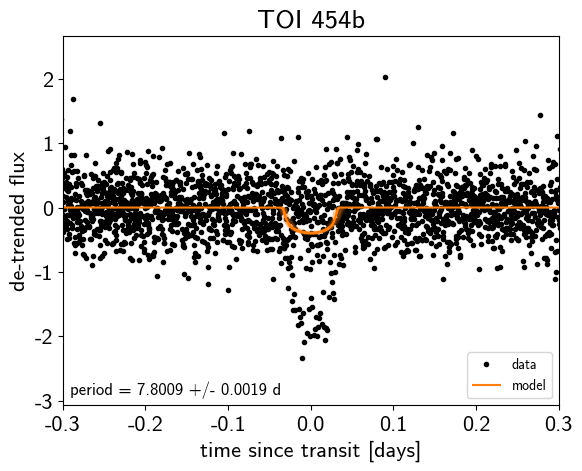

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

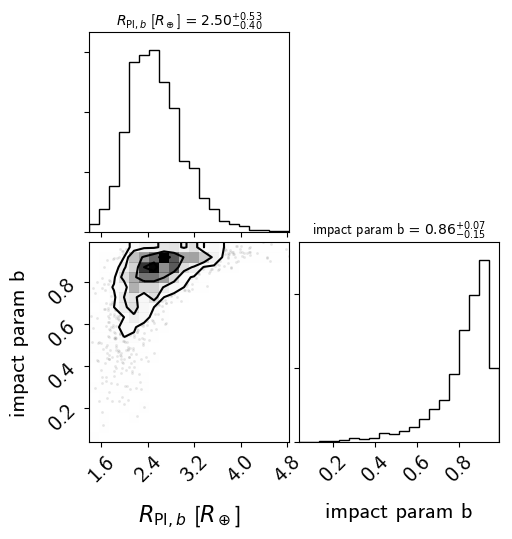

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

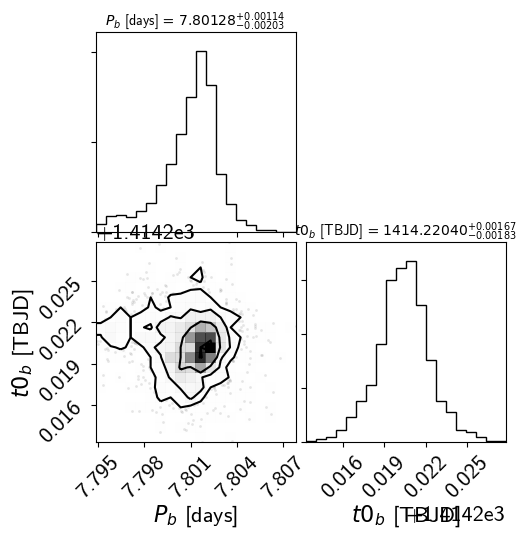

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

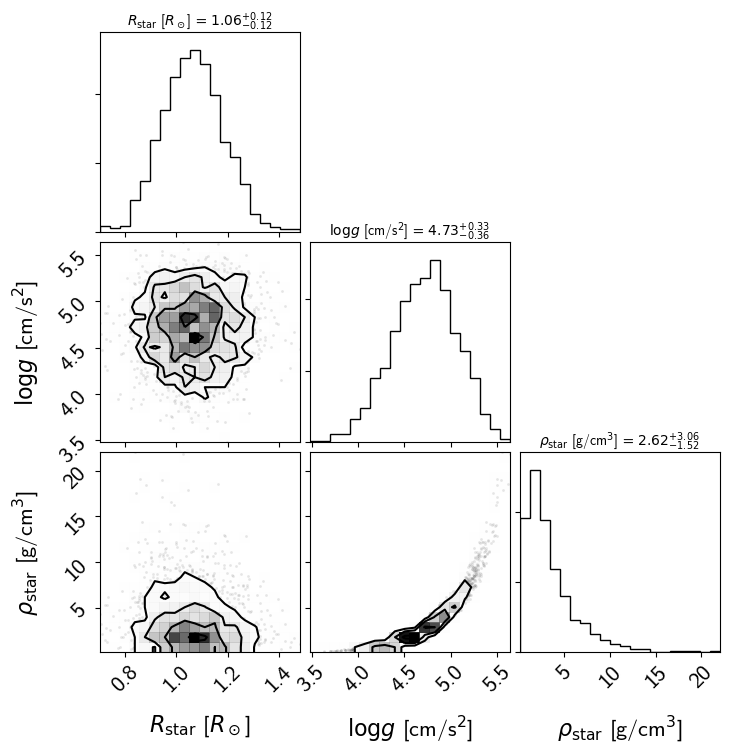

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3